## Описание проекта

**Заголовок:** Разработка решений HR-аналитики для компании «Работа с заботой»

**Описание проекта:** HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.  

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.  

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. В связи с этим перед нами стоит две задачи:
 - Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
 - Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Цель проекта:**  Сократить риски для компании, связанные с внезапными увольнениями важных сотрудников.

**Ход проекта:** 
- Описание данных предоставленные "Работа с заботой"
- Предсказание уровня удовлетворенности
    - Подготовка данных: загрузка, описание, анализ общей информации из датасетов "Работа с заботой"
    - Предобработка данных: пропуски, дубликаты, типы данных
    - Исследовательский анализ данных
    - Подготовка данных для машинного обучения
    - Обучение моделей
    - Выводы
- Предсказание увольнения сотрудника из компании
    - Подготовка данных: загрузка, описание, анализ общей информации из датасетов "Работа с заботой"
    - Предобработка данных: пропуски, дубликаты, типы данных
    - Исследовательский анализ данных
        - Портрет уволившегося сотрудника
        - Проверка гипотез
    - Добавление нового входного признака 
    - Подготовка данных для машинного обучения
    - Обучение моделей
    - Выводы


**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций бизнесу

С помощью данного исследования мы стремимся:
- дать HR отделу два инструмента (модели) для предсказания уровня удовлетворенности и вероятности увольнения сотрудника, для сокращения рисков компании.

### Описание данных

Первая задача

`id` — уникальный идентификатор сотрудника;  
`dept` — отдел, в котором работает сотрудник;  
`level` — уровень занимаемой должности;  
`workload` — уровень загруженности сотрудника;  
`employment_years` — длительность работы в компании (в годах);  
`last_year_promo` — показывает, было ли повышение за последний год;  
`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;  
`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;  
`salary` — ежемесячная зарплата сотрудника;  
`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.  

Предоставлены данные в нескольких таблицах:

Тренировочная выборка:
 - train_job_satisfaction_rate.csv

Входные признаки тестовой выборки:
 - test_features.csv

Целевой признак тестовой выборки:
 - test_target_job_satisfaction_rate.csv

Вторая задача

Для этой задачи мы можем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

Данные в нескольких таблицах:   
Тренировочная выборка:

 - train_quit.csv

Входные признаки тестовой выборки те же, что и в прошлой задаче:
- test_features.csv

Целевой признак тестовой выборки:  
- test_target_quit.csv

## Импорты библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import time
import phik
import shap
import warnings
import os

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    classification_report,
    roc_curve,
    RocCurveDisplay
)
from phik import phik_matrix, report
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import export_text


In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Предсказание уровня удовлетворенности


### Загрузка данных

#### Общие сведения датасетов

In [4]:
#Функция для импорта в df и проверка
def import_info_data(way, sep=',', decimal='.'):
    data_path = os.path.join('..', 'data', way)
    data = pd.read_csv(data_path, sep=sep, decimal=decimal)
 
    display(data.head(5))
    display(data.info()) 
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    print(f'Количество пропусков: {data.isna().sum()}')
    print(f'''Размер датафрейма: {data.shape}''')
    return data

In [5]:
train_job_satisfaction_rate = import_info_data('train_job_satisfaction_rate.csv')


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Размер датафрейма: (4000, 10)


In [6]:
test_features = import_info_data('test_features.csv')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Размер датафрейма: (2000, 9)


In [7]:
test_target_job_satisfaction_rate = import_info_data('test_target_job_satisfaction_rate.csv')

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
job_satisfaction_rate    0
dtype: int64
Размер датафрейма: (2000, 2)


#### Выводы

Все 3 датафрейма загрузились без проблем. 

Столбцы совпадают с описанием.
Явные пропуски в двух таблицах.
Явных дубликатов не видно.
Типы данных корректны.

Общая информация о датасетах предопределила последующие шаги в предобработке:

- поиск и обработка неявных дублей
- поиск и обработка пропусков


### Предобработка данных

In [8]:
def unique (data):  
    for column in data.columns[data.dtypes=='object']:
        print(f'''Количество уникальных значений в столбце `{column}`: {data[column].nunique()}''')
        print(data[column].unique(), end='\n'*2)     
    return

In [9]:
unique(train_job_satisfaction_rate)

Количество уникальных значений в столбце `dept`: 5
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Количество уникальных значений в столбце `level`: 3
['junior' 'middle' 'sinior' nan]

Количество уникальных значений в столбце `workload`: 3
['medium' 'high' 'low']

Количество уникальных значений в столбце `last_year_promo`: 2
['no' 'yes']

Количество уникальных значений в столбце `last_year_violations`: 2
['no' 'yes']



In [10]:
train_job_satisfaction_rate[train_job_satisfaction_rate['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [11]:
train_job_satisfaction_rate[train_job_satisfaction_rate['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [12]:
unique(test_features)

Количество уникальных значений в столбце `dept`: 6
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Количество уникальных значений в столбце `level`: 3
['junior' 'middle' 'sinior' nan]

Количество уникальных значений в столбце `workload`: 4
['medium' 'low' 'high' ' ']

Количество уникальных значений в столбце `last_year_promo`: 2
['no' 'yes']

Количество уникальных значений в столбце `last_year_violations`: 2
['no' 'yes']



In [13]:
test_features[(test_features['dept']==' ')+(test_features['dept'].isna()==True)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


In [14]:
test_features[test_features['level'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [15]:
test_features[test_features['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


#### Выводы

Предобработка выявила пропуски в таблицах. Их мы обработаем в пайплайне при подготовке данных к МО. Неявные дубликаты не обнаружены.

### Исследовательский анализ

#### train_job_satisfaction_rate

In [16]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [17]:
train_job_satisfaction_rate.columns 

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [18]:
cat_features_col = ['dept','level','workload','last_year_promo','last_year_violations']
num_features_col = ['salary','job_satisfaction_rate']
num_dis_features_col = ['employment_years','supervisor_evaluation']

In [19]:
def vis_cat_features(df, column):
    for col in column:
        plt.figure(figsize=(18,6))
        plot = sns.countplot(data = df, y=col)
        plot.set_title(f'Рапределение по {col}', fontsize=16)
        plot.set_xlabel('Количество сотрудников', fontsize=14)
        plot.set_ylabel('')
        plt.show()

In [20]:
def viz_num_features(df, column, dis=False):
    for col in column:
        sns.set(rc={"figure.figsize": (18, 6)})
        fig,axes=plt.subplots(1,2)
        if dis==False:
            sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
            axes[0].set(ylabel='Количество юзеров', xlabel=col, title='Гистограмма')
        else:
            sns.countplot(data=df, x=col, ax=axes[0])
            axes[0].set(ylabel='Количество юзеров', xlabel=col, title='Countplot')
        sns.boxplot(data=df[col], ax=axes[1])
        axes[1].set(ylabel=col, title='Ящик с усами')
        plt.show()

##### Визуализация категориальных признаков

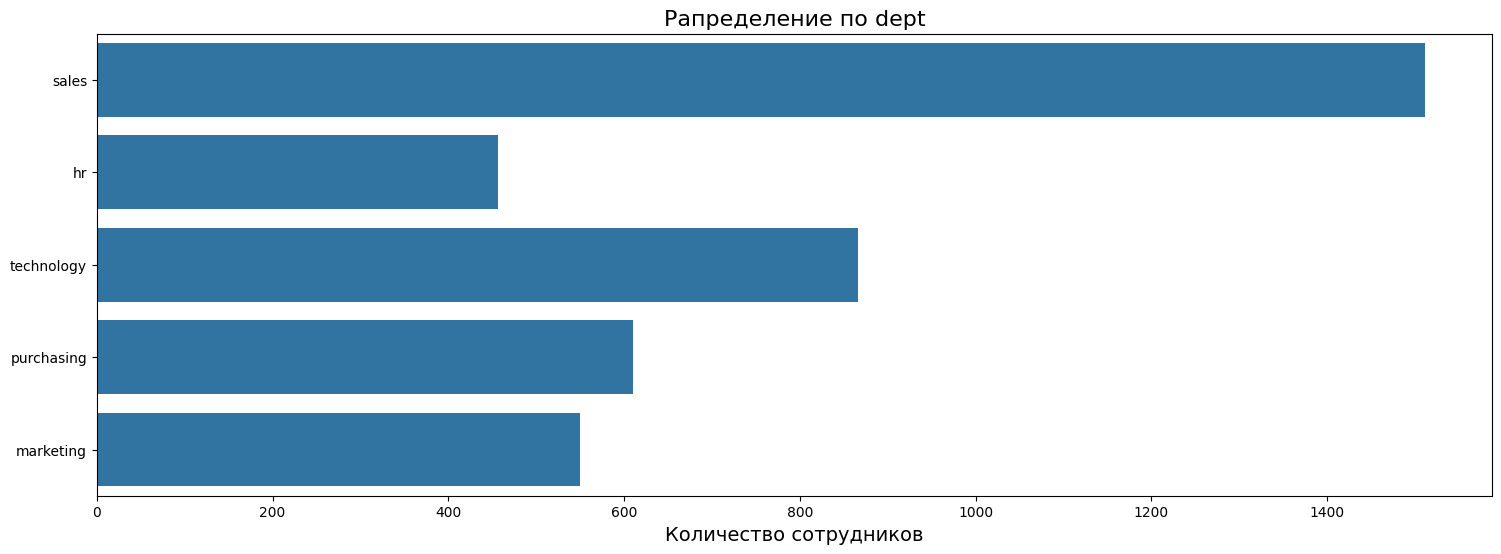

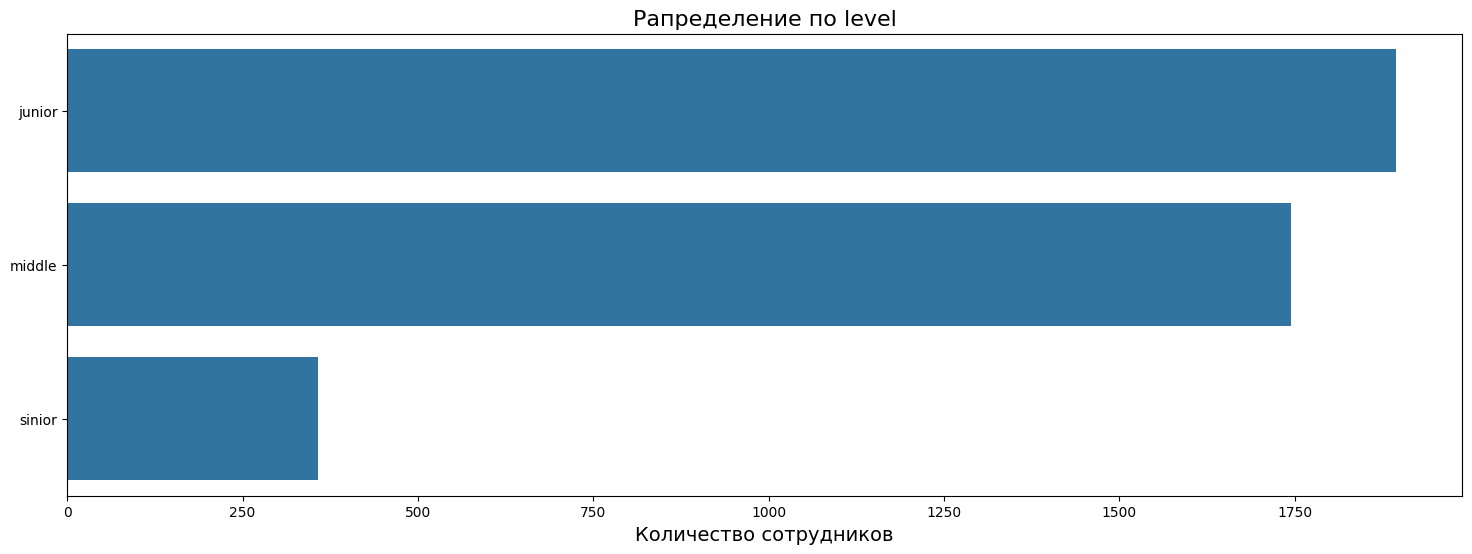

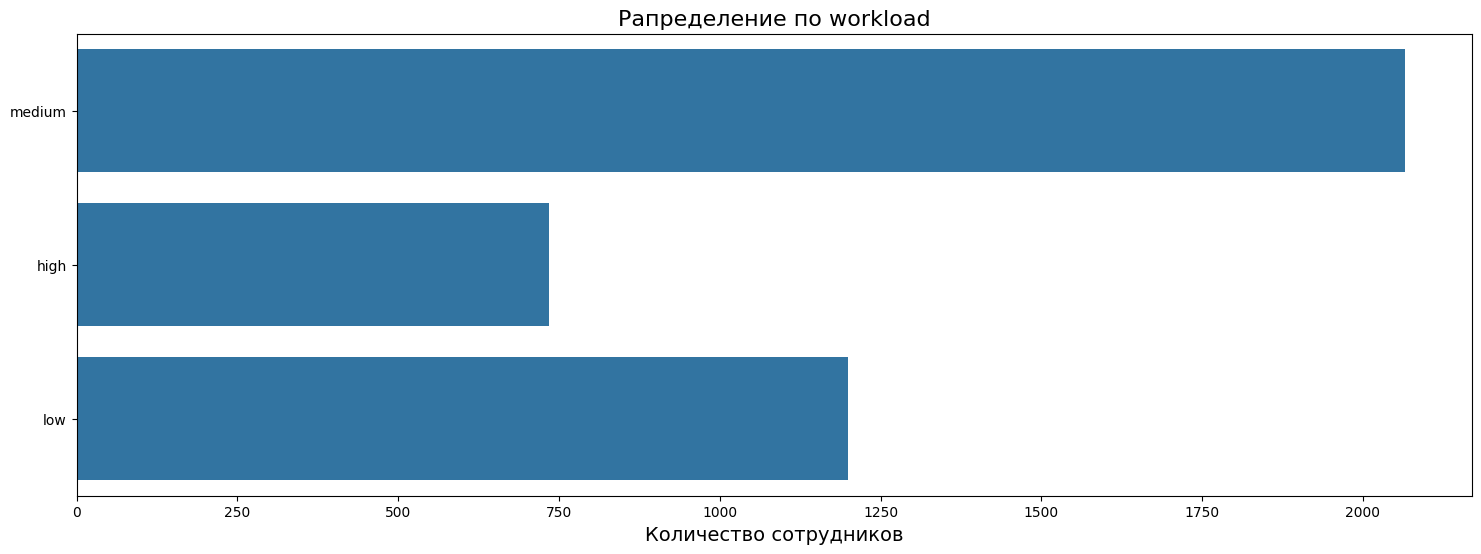

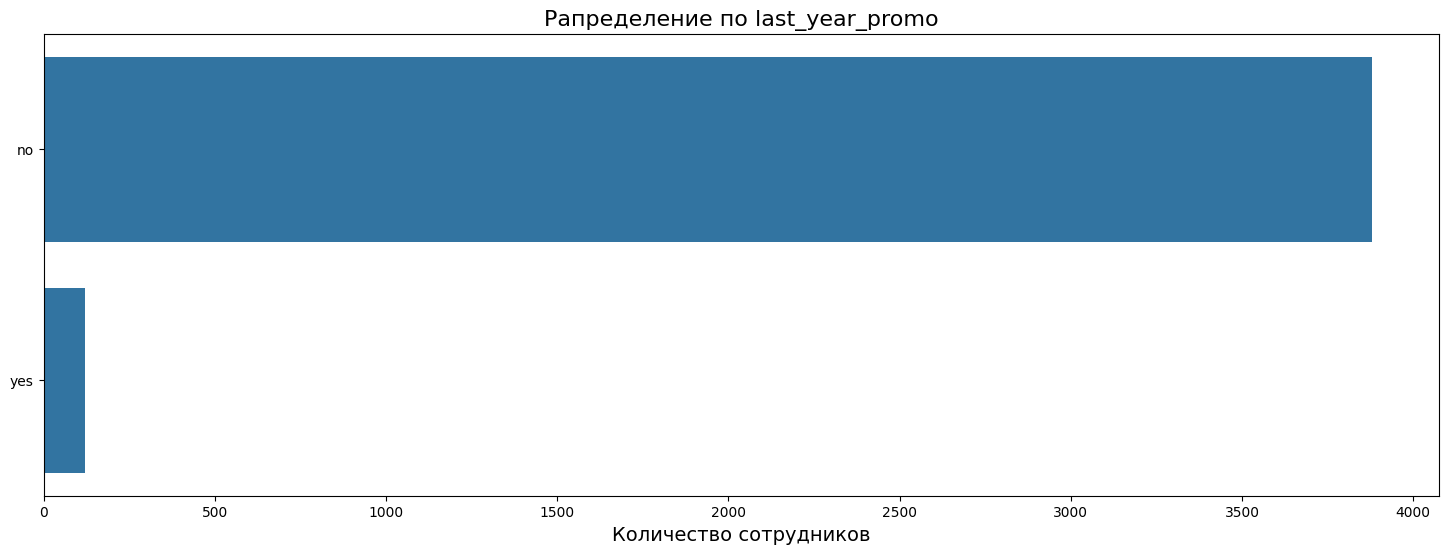

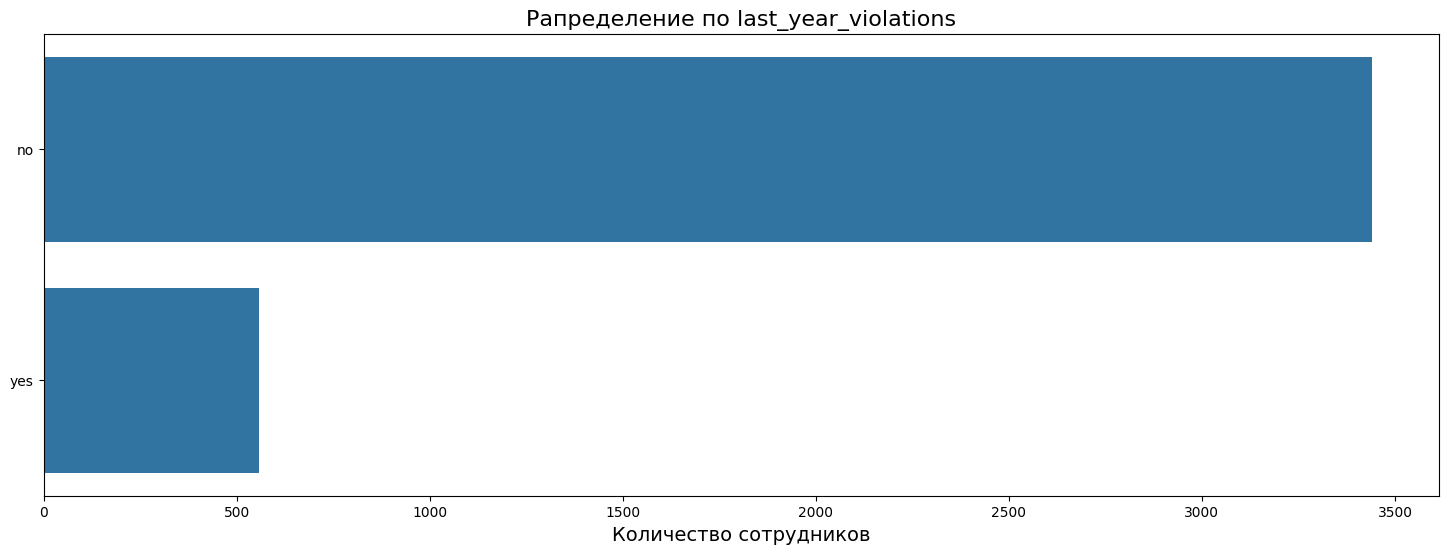

In [21]:
vis_cat_features(train_job_satisfaction_rate, cat_features_col)

##### Выводы

По категориальным признакам можно сделать следующие выводы:

- основное число работников составляют продавцы, на втором месте технологический отдел;  
- по уровню занимаемой должности , все выглядит так как должно -основное число сотрудников это junior, но стоит отметить также значительное число среднего уровня;  
- загруженность персонала , также находится в основном на среднем уровне, но компании стоит обратить внимание на достаточно высокий уровень мало загруженных сотрудников.  
- видим что в компании за последний год практически не было повышения, что достаточно логично учитывая средний стаж работников — 3 года., но с другой стороны повышения можно использовать как дополнительный стимул для повышения производительности труда.
- по дисциплине стоит отметить достаточно низкий уровень нарушений трудового договора, но все же они есть. Стоит обратить внимание на них и носят ли эти нарушения систематический характер.

##### Визуализация количественных признаков

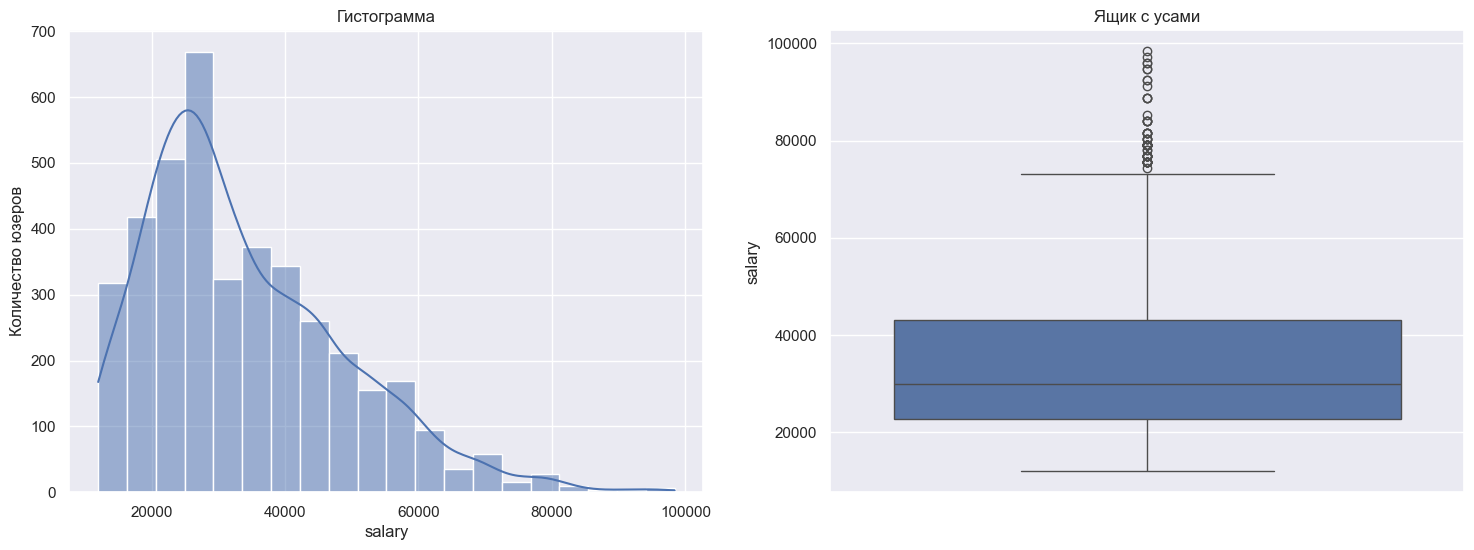

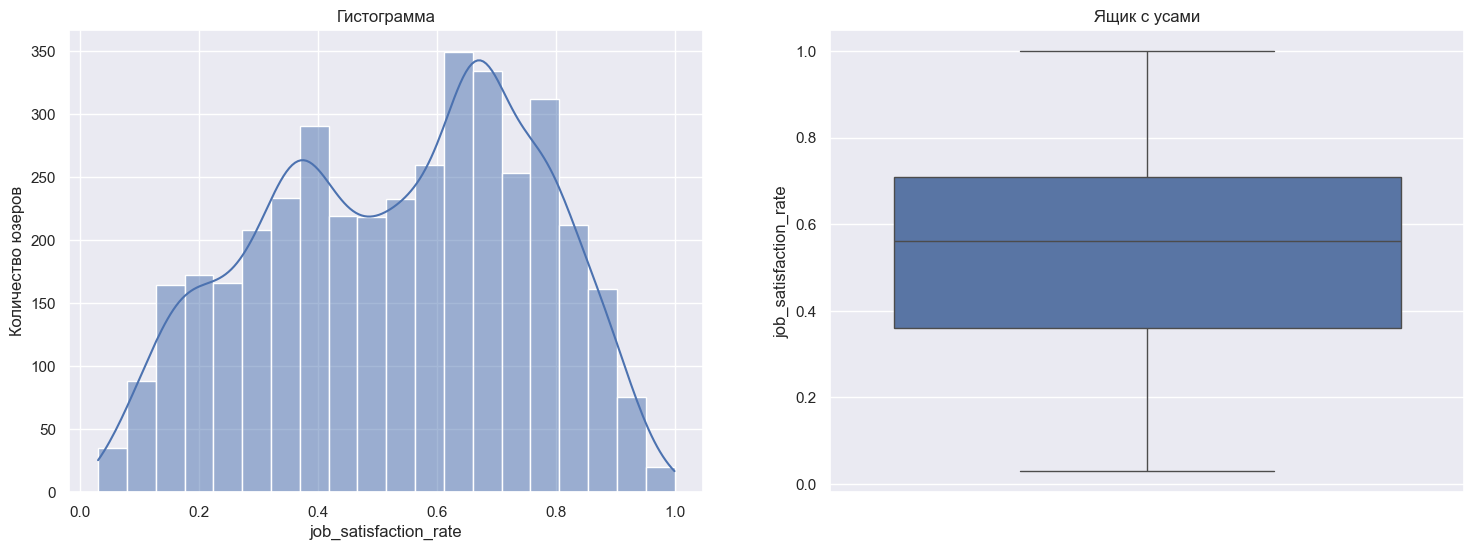

In [22]:
viz_num_features(train_job_satisfaction_rate, num_features_col)

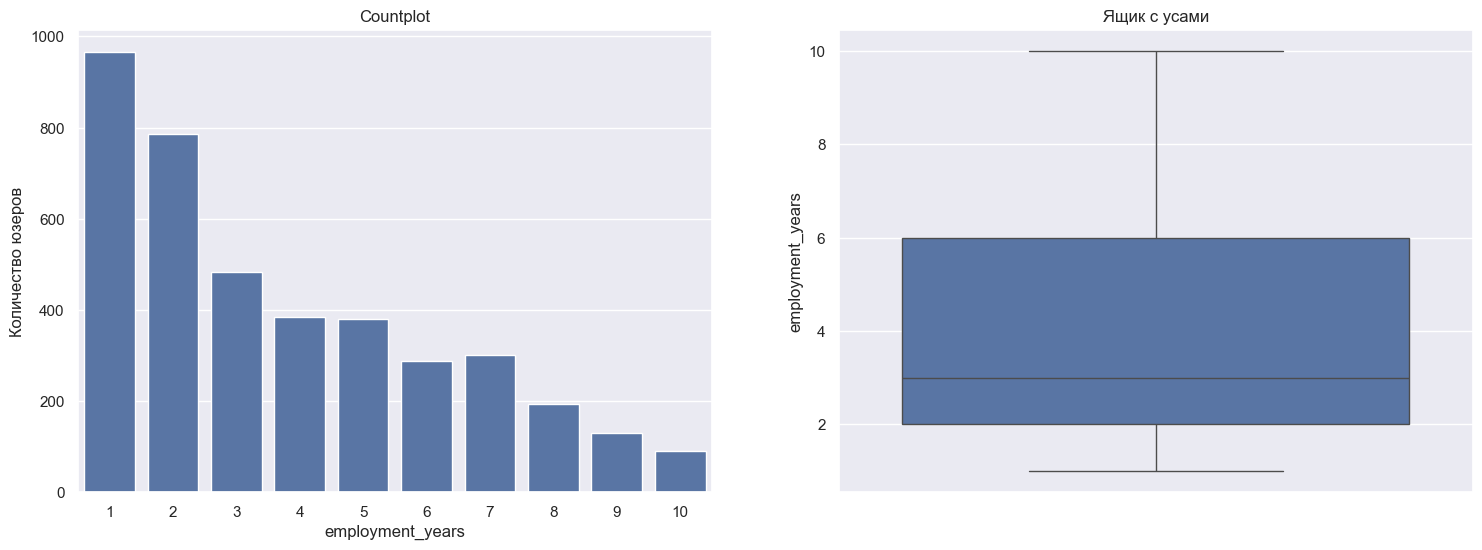

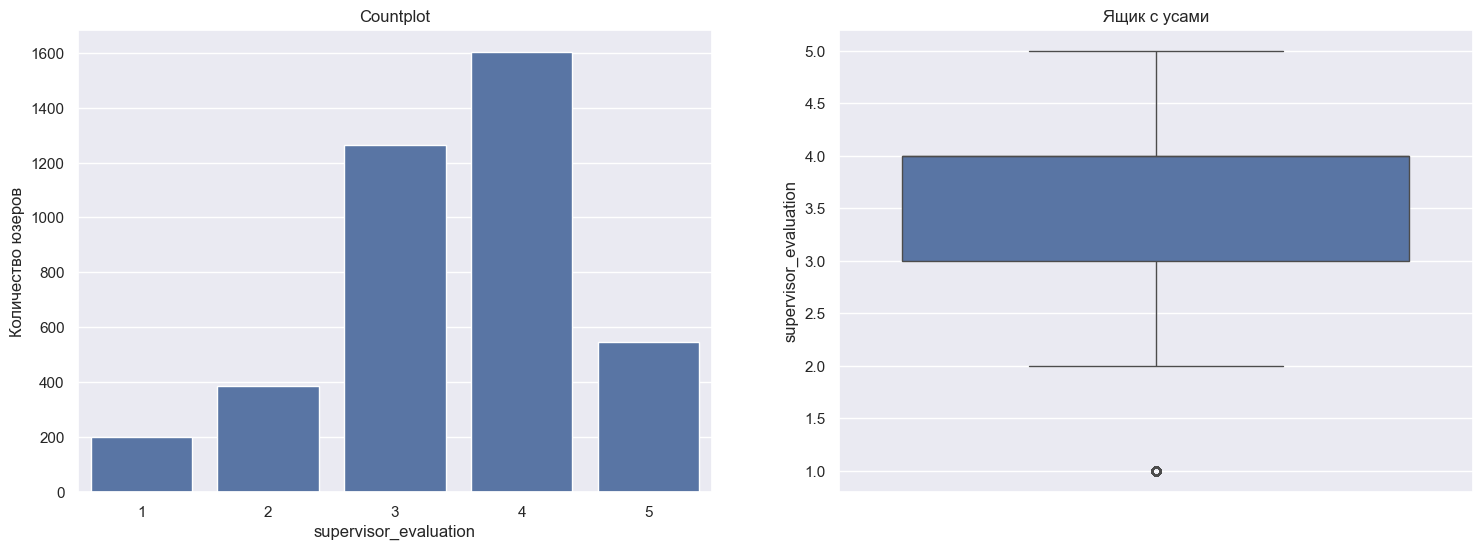

In [23]:
viz_num_features(train_job_satisfaction_rate, num_dis_features_col, dis=True)

##### Выводы
По количественным признакам можно сделать следующие выводы:

- основное число работников работают в компании от 1 до 6 лет. В среднем рабочей стаж в компании составляет 3 года.
- в основном сотрудники оцениваются по качеству работы на 3 и 4 балла. Но есть и те у кого оценка равна 1. 
- несмотря на несколько выбросов средняя зарплата не намного больше медианной.
- удовлетворенность сотрудника работой соответствует оценке качества — хороший середнячок. В целом условия и работа неплохие, но можно и лучше.
- в id никаких закономерностей нет, в дальнейшем можно убрать его в индекс

#### test_features

In [24]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [25]:
test_features.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')

In [26]:
cat_features_col_test = ['dept','level','workload','last_year_promo','last_year_violations']
num_features_col_test = ['id','salary']
num_dis_features_col_test = ['employment_years','supervisor_evaluation']

##### Визуализация категориальных признаков

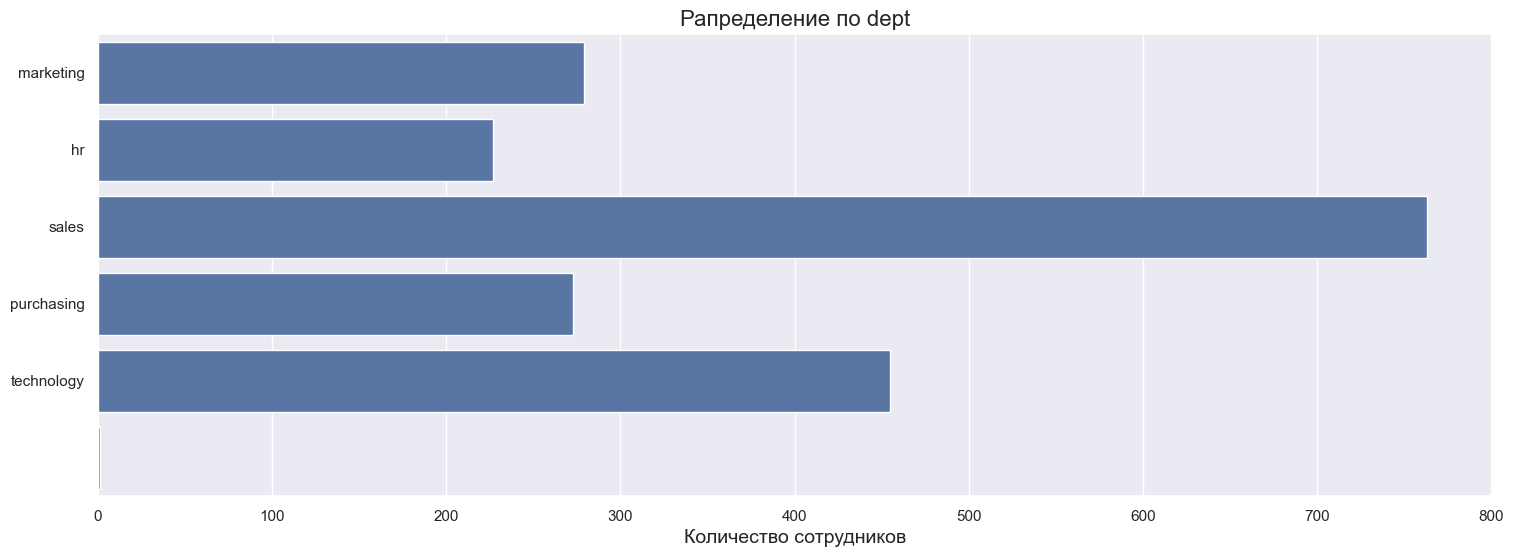

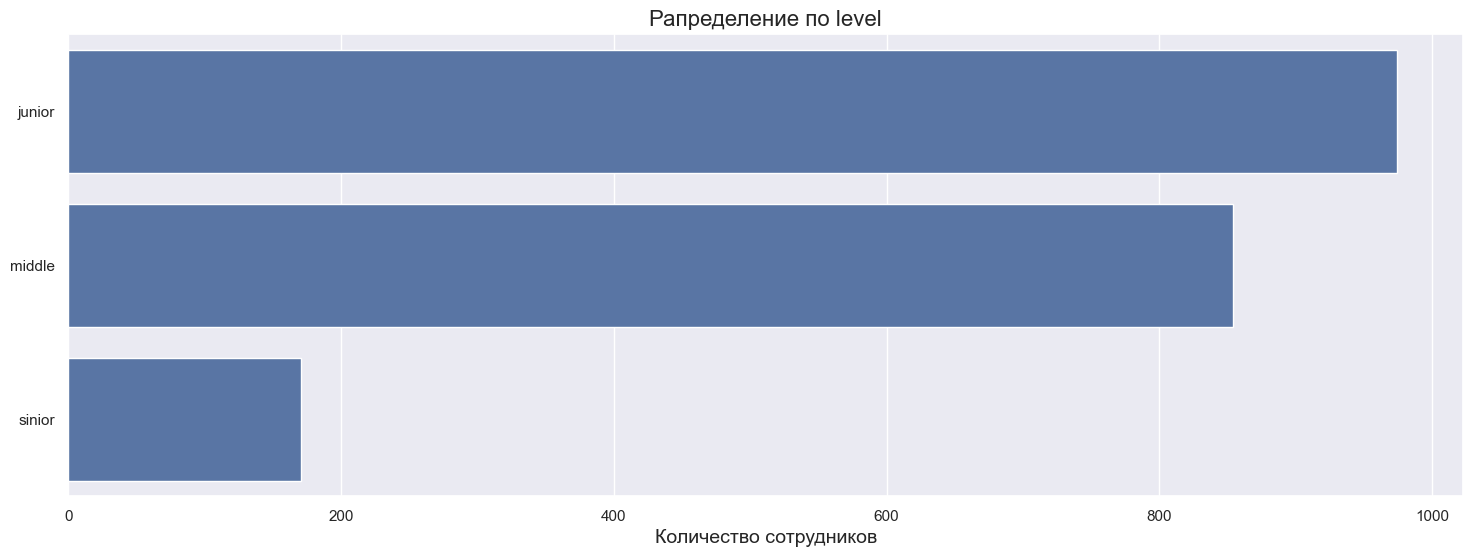

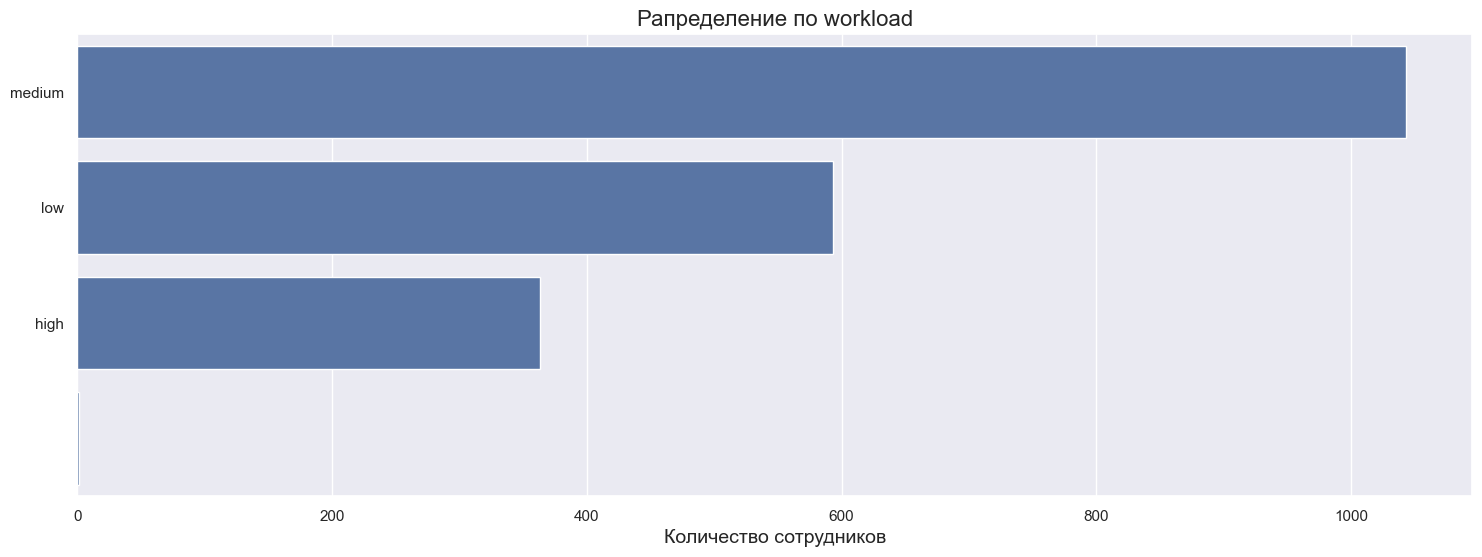

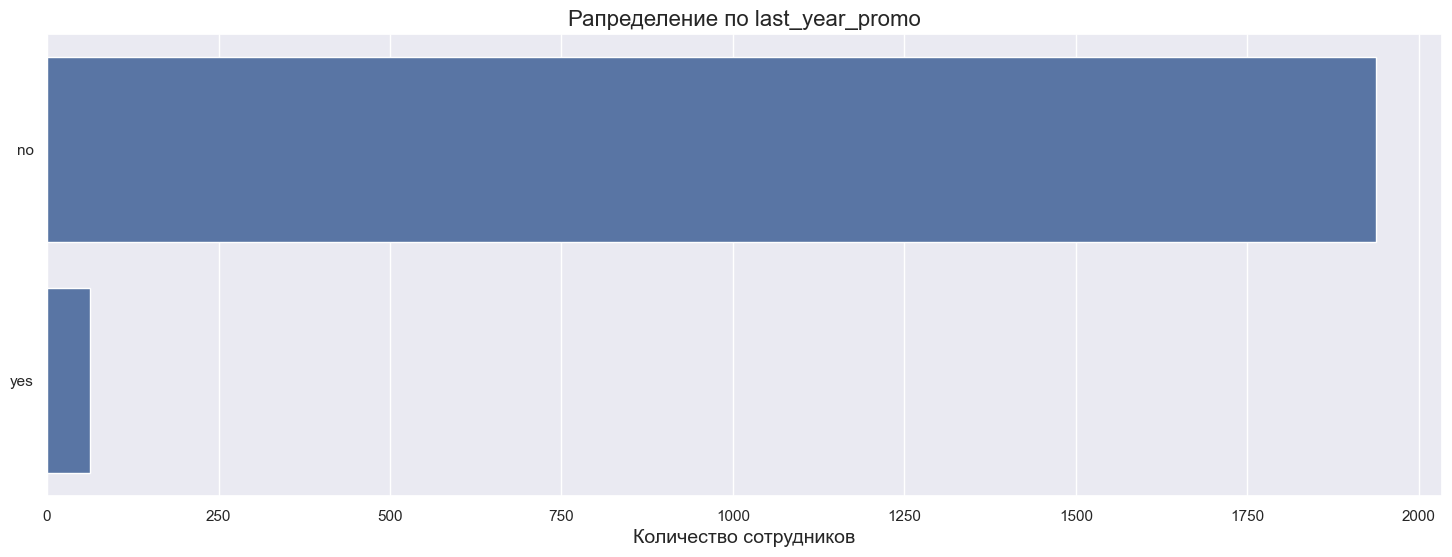

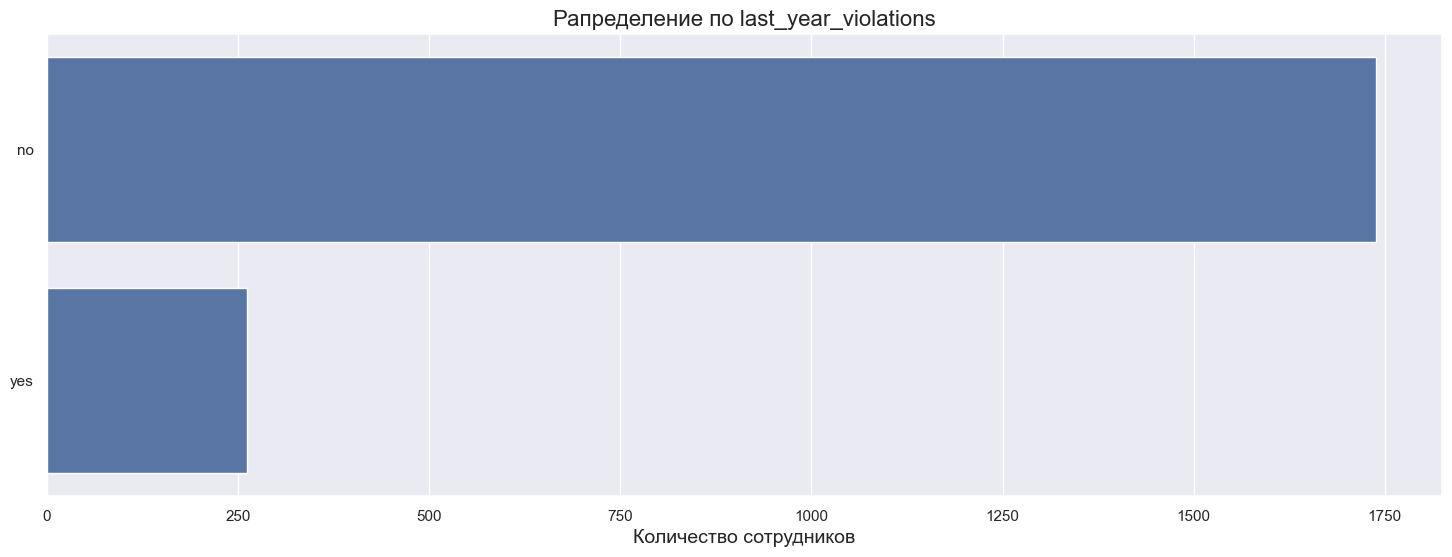

In [27]:
vis_cat_features(test_features,cat_features_col_test)

##### Визуализация количественных признаков

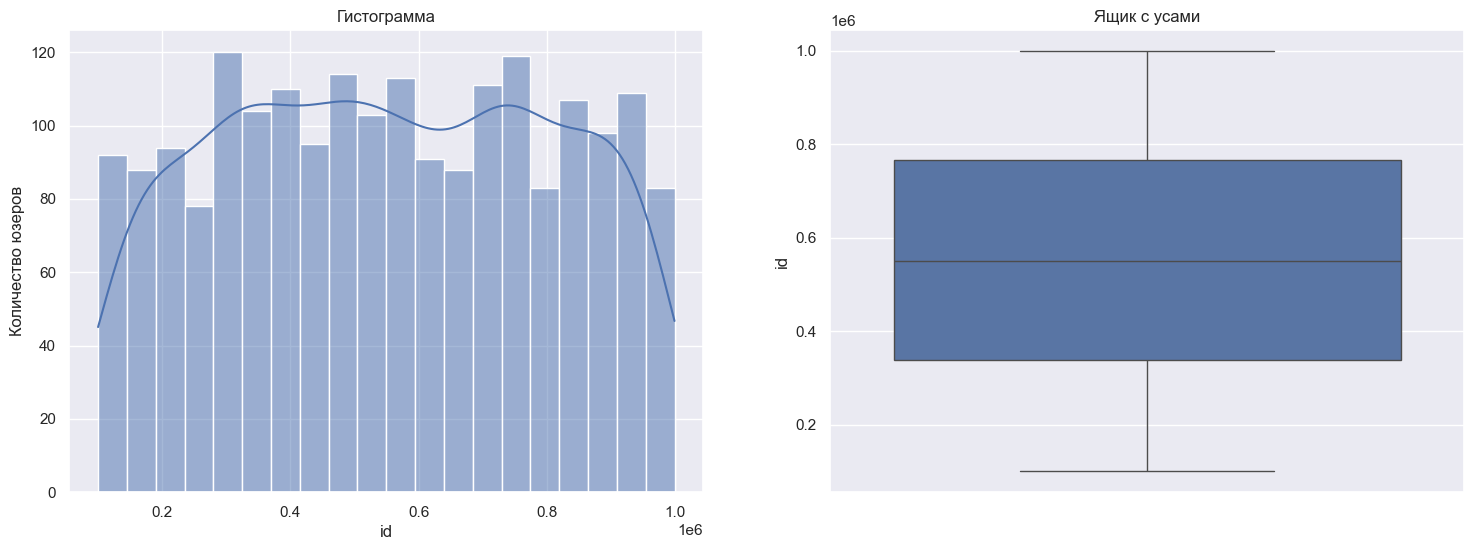

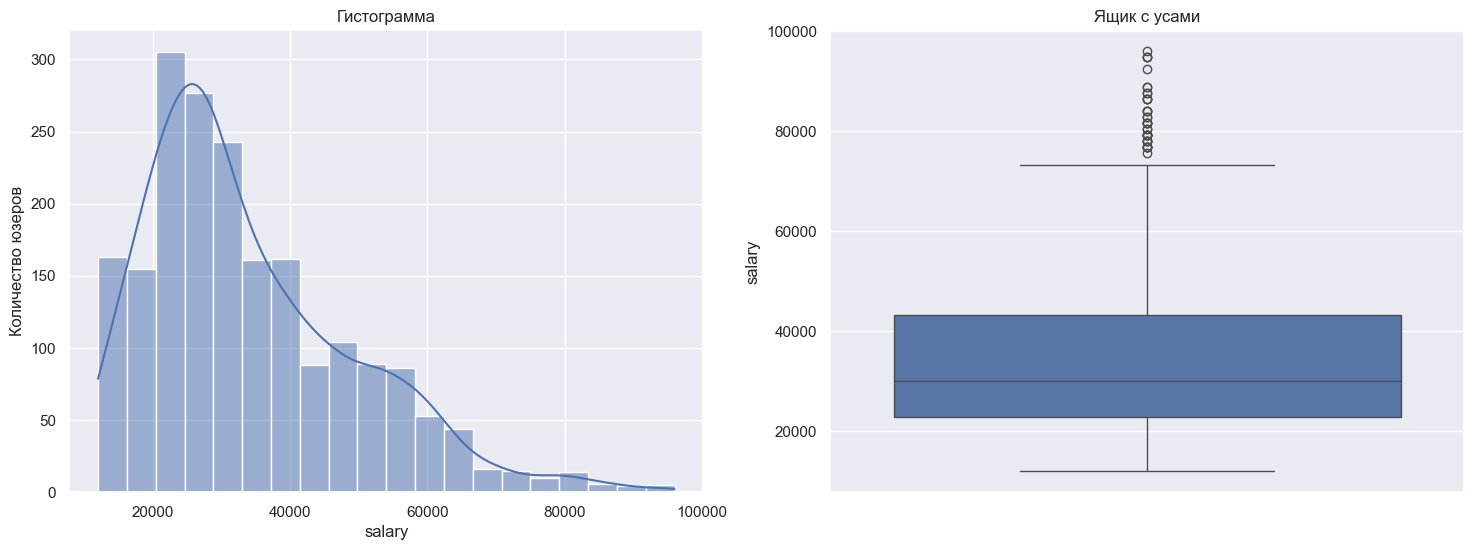

In [28]:
viz_num_features(test_features,num_features_col_test)

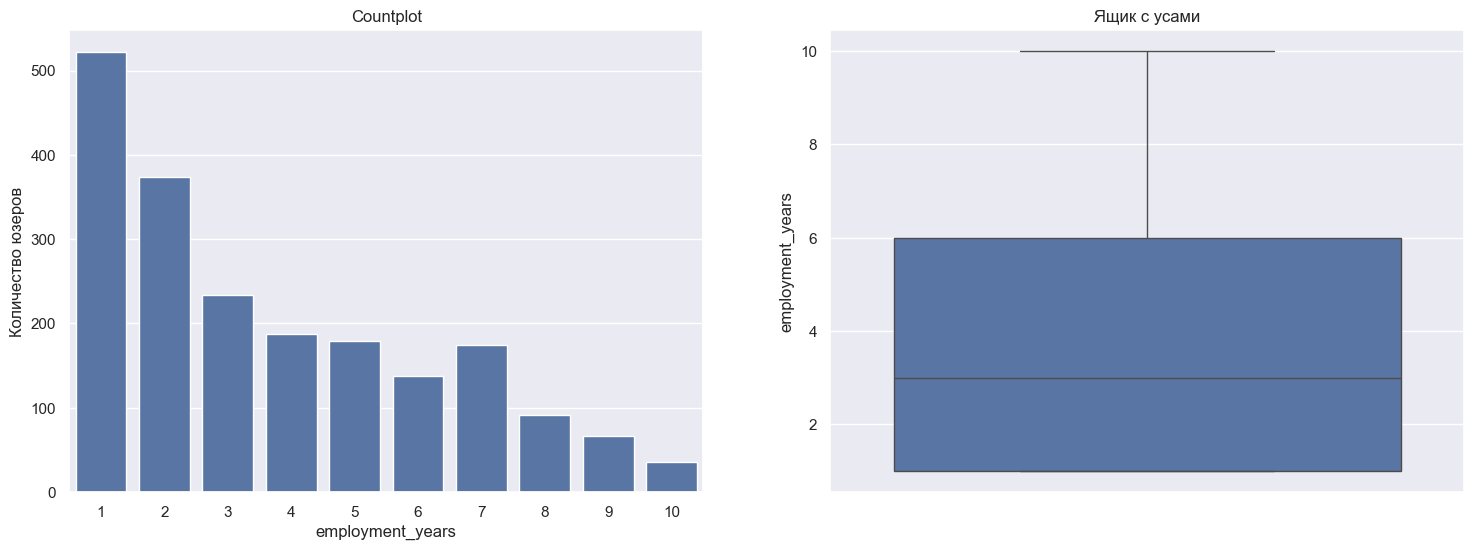

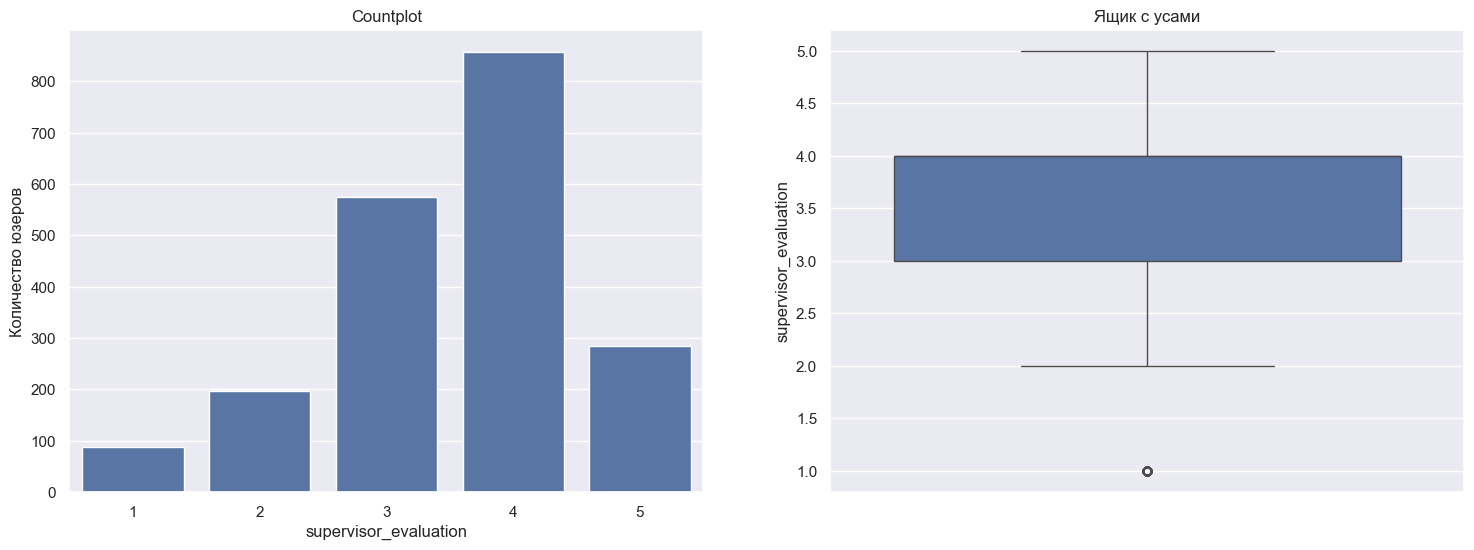

In [29]:
viz_num_features(test_features,num_dis_features_col_test,dis=True)

##### Выводы

При анализе тестовой выборки ничего отличительного от тренировочной необнаружено

#### Корреляционный анализ

In [30]:
def corr_matrix(data):
    data = data.drop(['id'], axis=1)
    corr_matrix = data.phik_matrix(interval_cols=num_features_col_test)
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='GnBu')
    plt.title('Матрица корреляции')
    plt.show()
    return

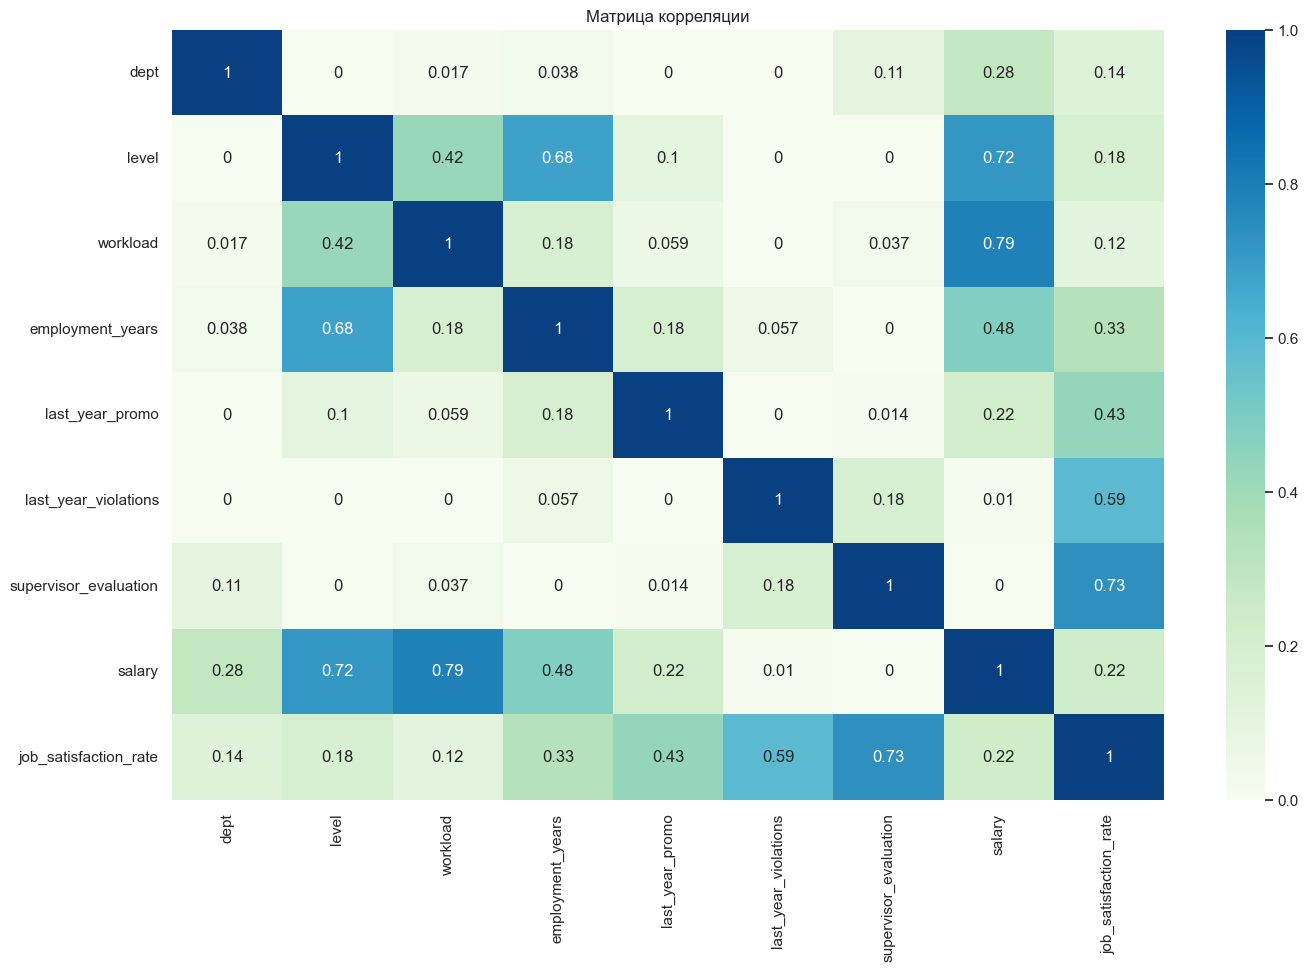

In [31]:
corr_matrix(train_job_satisfaction_rate)

##### Выводы

C целевым признаком коррелируют: `supervisor_evaluation` и `last_year_violations`. Корреляция зарплаты при этом достаточно мала. Не всем важна только ЗП!)

`salary` коррелирует с `level`, `workload`,`employment_years`, что в целом логично.

Мультиколинеарности не наблюдаю.

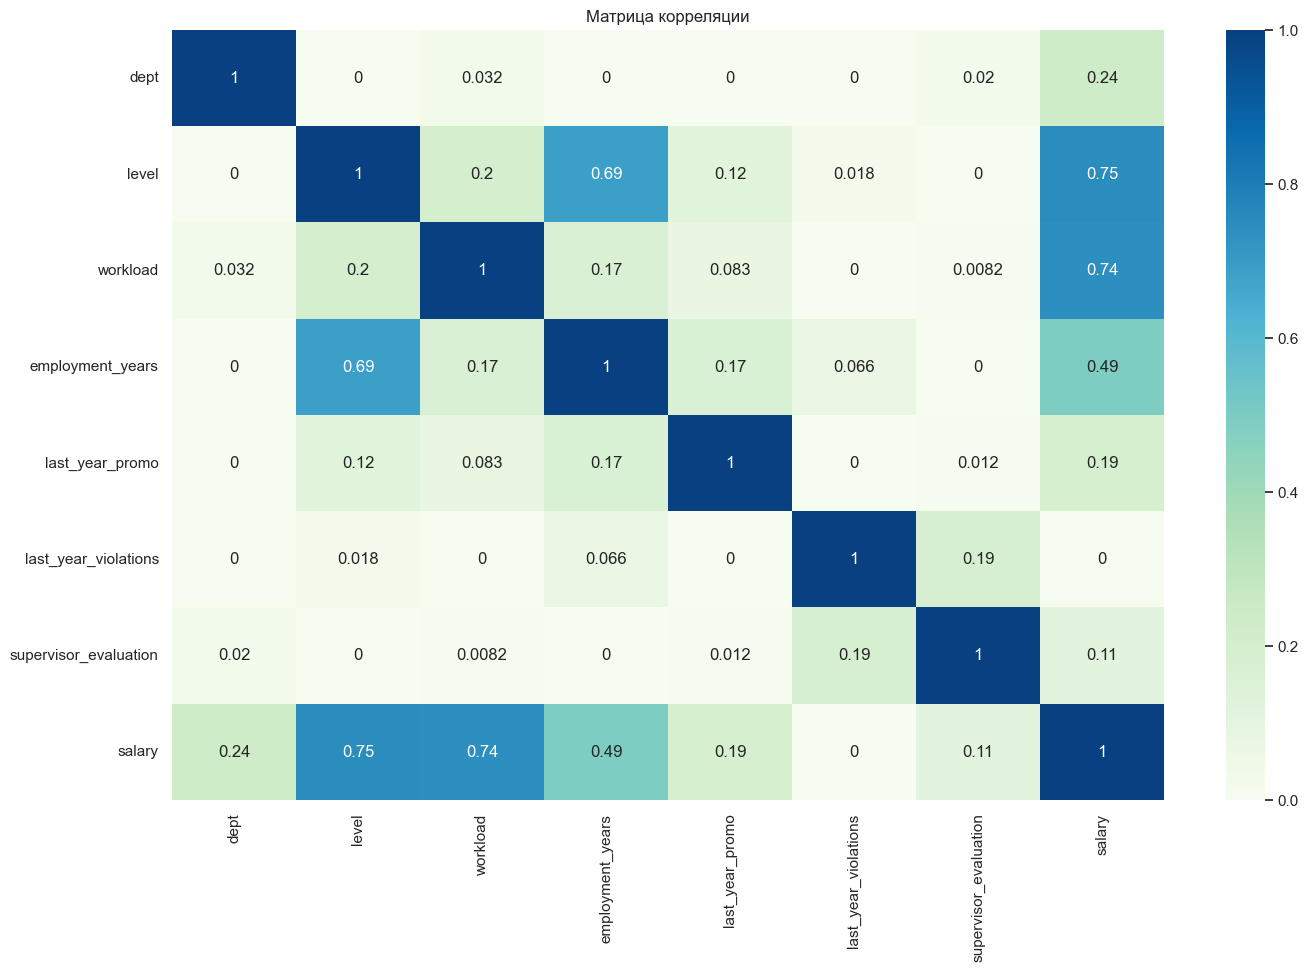

In [32]:
corr_matrix(test_features)

### Подготовка данных

In [33]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id')

In [34]:
train_job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [35]:
X_train = train_job_satisfaction_rate.drop(columns='job_satisfaction_rate')
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

test_features = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')
X_test = test_features.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_features['job_satisfaction_rate']

### Пайплайны. Обучение модели

dept, last_year_promo, last_year_violations — будем кодировать с помощью OneHotEncoder.  
level, workload — с помощью OrdinalEncoder.  
employment_years, supervisor_evaluation, salary - нужно масштабировать.  

In [36]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])
 
param_grid = [

    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 21),
        'model__min_samples_split': range(2, 21),
        'model__max_features': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]


def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))



smape_scorer = make_scorer(score_func=smape, greater_is_better=False)
 
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=10,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# обучаем лучшую модель на тренировочных данных
r_search.fit(X_train, y_train)

# выводим на экран лучшую модель
print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print(f'Параметры лучшей модели:\n{r_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(r_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [37]:
best_model = r_search.best_estimator_
print(f'Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: {round(r_search.best_score_*(-1),4)}')

Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 14.7756


In [38]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)),4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 13.7406


/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [39]:
cv_results = pd.DataFrame(r_search.cv_results_)
cv_results
# Добавляем колонку с   моделями 
cv_results['модель'] = cv_results['params'].apply(lambda x: x.__class__.__name__)

detailed_names = {

    'mean_score_time': 'время_предсказания',
    'mean_test_score': 'метрика_на_кроссвалидации',
    'rank_test_score': 'место_по_метрике'
}

cv_results_renamed = cv_results.rename(columns=detailed_names)
best_models = (
    cv_results_renamed
    .sort_values('место_по_метрике')
    .reset_index()
)
# Выводим интересующие нас cтолбцы
best_models[['модель', 'время_предсказания', 'метрика_на_кроссвалидации', 'место_по_метрике']]
# cv_results_renamed

,модель,время_предсказания,метрика_на_кроссвалидации,место_по_метрике
0,dict,0.013585,-14.775551,1
1,dict,0.007575,-14.960795,2
2,dict,0.013388,-15.031343,3
3,dict,0.013098,-15.722295,4
4,dict,0.012626,-15.881294,5
5,dict,0.012625,-17.851117,6
6,dict,0.014175,-18.521201,7
7,dict,0.011413,-19.110314,8
8,dict,0.013687,-21.188961,9
9,dict,0.012117,-23.616754,10


#### Выводы

Модель с оптимальными гиперпараметрами демонстрирует хорошую сбалансированность между точностью, скоростью и устойчивостью.   
Полученная метрика SMAPE 13.74% на тестовой выборке свидетельствует о практической применимости модели для решения поставленной задачи.  
Модель не показывает признаков переобучения и обладает удовлетворительной обобщающей способностью. 

#### Анализ важности признаков

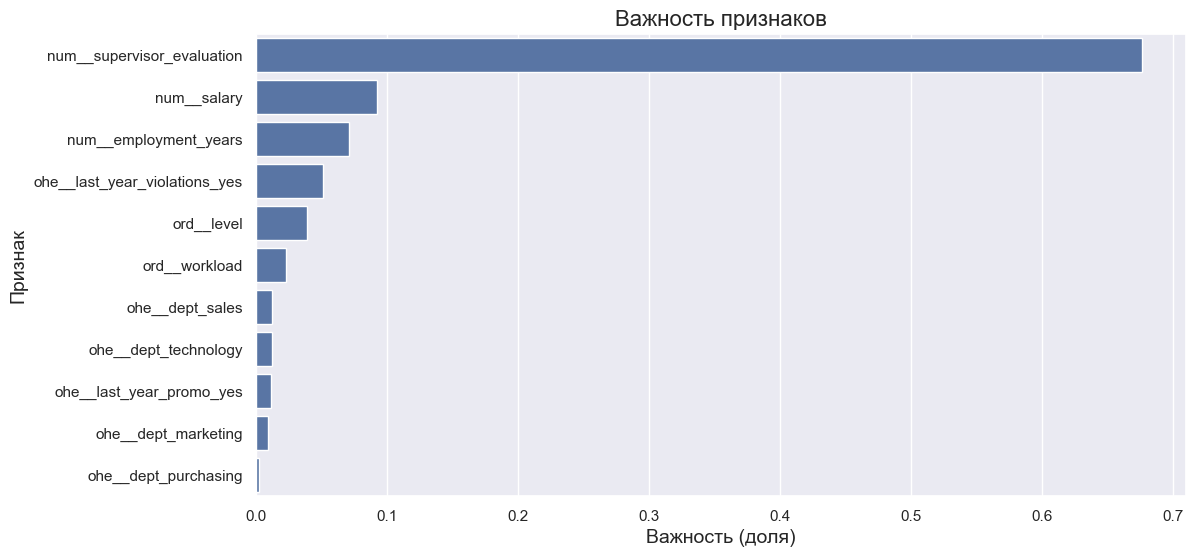

In [40]:
feature_importances = pd.DataFrame(
    {
        'Feature': best_model.named_steps['preprocessor'].get_feature_names_out(),
        'Importance': best_model.named_steps['model'].feature_importances_
    })
# отсортируйте таблицу от большего значения важности к меньшему и выведите результат
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data = feature_importances,
    y = 'Feature',
    x = 'Importance'
)
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)
plt.show()

Модель определяет следующие три признака как наиболее важные для прогнозирования:

Оценка руководителя (num_supervisor_evaluation) - лидер по важности
Уровень зарплаты (num_salary) - второй по значимости  
Стаж работы (num_employment_years) - третий по важности  

Это свидетельствует о том, что материальные и карьерные факторы оказывают наибольшее влияние на исследуемую целевую переменную.

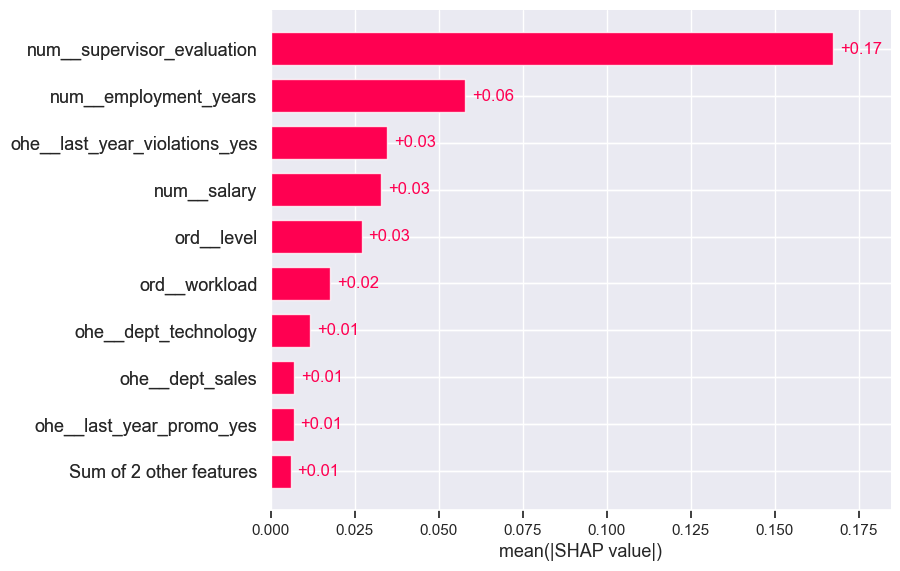

In [41]:
# Получаем модель и препроцессор
tree_model = best_model.named_steps['model']
preprocessor = best_model.named_steps['preprocessor']

# Преобразуем данные
X_transformed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Создаем объяснитель
explainer = shap.TreeExplainer(tree_model)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_transformed)

# Создаем Explanation объект
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_transformed,
    feature_names=feature_names
)

shap.plots.bar(explanation, max_display=10)

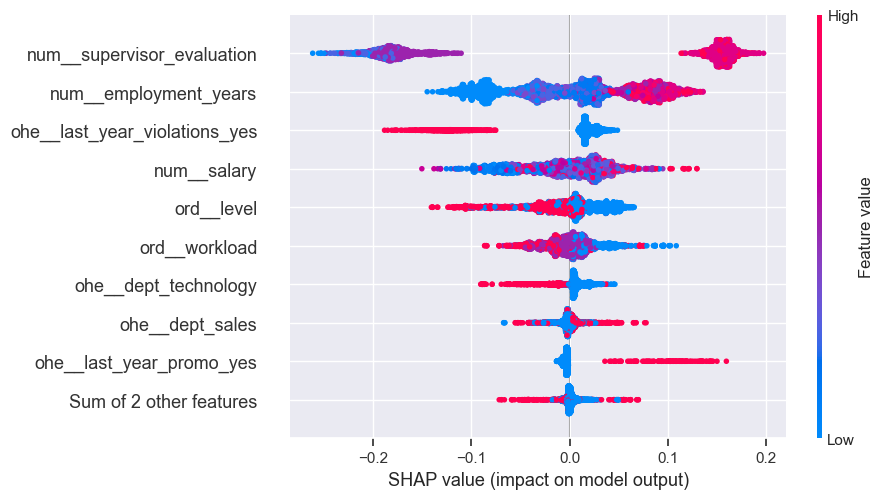

In [43]:
shap.plots.beeswarm(explanation, max_display=10)


#### Выводы

Признак `num_supervisor_evaluation` демонстрирует наибольшее влияние на модель.
Высокое значение признака (High) оказывает положительное влияние на выход модели

Это подтверждает, что оценка руководителя является ключевым драйвером в модели принятия решений

- Высокая значимость оценки руководителя подчеркивает важность роли менеджеров в принятии кадровых решений  
- Стаж работы важнее, чем наличие нарушений в прошлом 
- арплата имеет умеренное влияние, что может указывать на ее роль как вторичного фактора  
- Уровень должности и отдел оказывают минимальное влияние  


Модель демонстрирует высокую степень зависимости от оценки руководителя, что с одной стороны делает ее интерпретируемой, а с другой - создает риски субъективности. Стаж работы является вторым по значимости фактором, но его влияние существенно меньше. Остальные признаки играют вспомогательную роль в модели принятия решений

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Экспертный вывод по графику! Не просто красивая картинка "построена", но описаны те моменты, которые дата-сайентист видит в ней!
</div>

#### Анализ остатков модели

/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


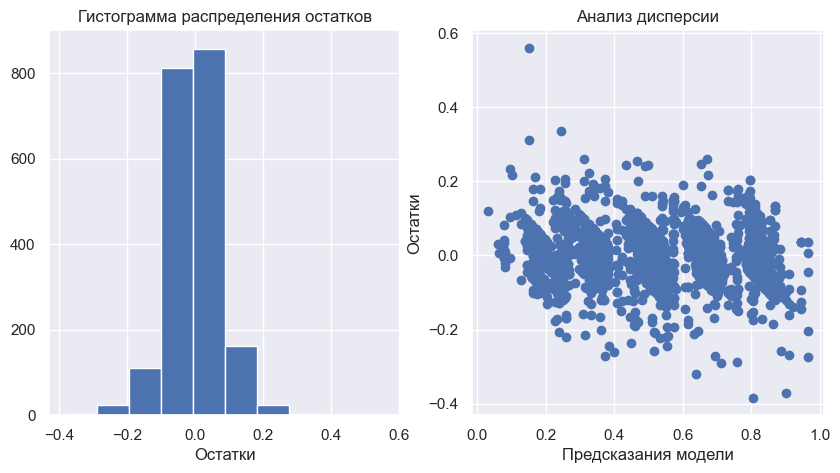

In [44]:
residuals = y_test - best_model.predict(X_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x= best_model.predict(X_test), y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

#### Выводы

Распределение остатков близко к нормальному с центром в нуле, что свидетельствует об отсутствии систематической ошибки. Равномерный разброс остатков относительно предсказанных значений подтверждает гомоскедастичность ошибок. 

## Предсказание увольнения сотрудника из компании

### Загрузка данных

#### Общие сведения датасетов

Данные в нескольких таблицах:  
Тренировочная выборка:  
train_quit.csv    

Входные признаки тестовой выборки те же, что и в прошлой задаче:    
test_features.csv    

Целевой признак тестовой выборки:     
test_target_quit.csv  

In [45]:
train_quit = import_info_data('train_quit.csv')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

Количество дубликатов: 0
Количество пропусков: id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Размер датафрейма: (4000, 10)


In [46]:
test_features_quit = test_features.copy()
test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


In [47]:
test_target_quit = import_info_data('test_target_quit.csv')

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Количество дубликатов: 0
Количество пропусков: id      0
quit    0
dtype: int64
Размер датафрейма: (2000, 2)


#### Выводы

2 датафрейма загрузились без проблем. 
Датафрейм `test_features_quit` - скопировали из `test_features`

Столбцы совпадают с описанием.
Явные пропуски в `test_features`.
Явных дубликатов не видно.
Типы данных корректны.

Общая информация о датасетах предопределила последующие шаги в предобработке:

- поиск и обработка неявных дублей
- поиск и обработка пропусков


### Предобработка данных

In [48]:
def unique (data):  
    for column in data.columns[data.dtypes=='object']:
        print(f'''Количество уникальных значений в столбце `{column}`: {data[column].nunique()}''')
        print(data[column].unique(), end='\n'*2)     
    return

In [49]:
unique(train_quit)

Количество уникальных значений в столбце `dept`: 5
['sales' 'purchasing' 'marketing' 'technology' 'hr']

Количество уникальных значений в столбце `level`: 3
['middle' 'junior' 'sinior']

Количество уникальных значений в столбце `workload`: 3
['high' 'medium' 'low']

Количество уникальных значений в столбце `last_year_promo`: 2
['no' 'yes']

Количество уникальных значений в столбце `last_year_violations`: 2
['no' 'yes']

Количество уникальных значений в столбце `quit`: 2
['no' 'yes']



In [50]:
unique(test_features_quit)

Количество уникальных значений в столбце `dept`: 6
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Количество уникальных значений в столбце `level`: 3
['junior' 'middle' 'sinior' nan]

Количество уникальных значений в столбце `workload`: 4
['medium' 'low' 'high' ' ']

Количество уникальных значений в столбце `last_year_promo`: 2
['no' 'yes']

Количество уникальных значений в столбце `last_year_violations`: 2
['no' 'yes']



In [51]:
test_features_quit[(test_features_quit['dept']==' ')|(test_features_quit['dept'].isna()==True)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
191,609865,NaN,junior,medium,1,no,no,1,20400,0.12
1196,832342,NaN,junior,medium,1,no,no,4,28800,0.61
1699,822186,,middle,medium,3,no,no,4,38400,0.64


In [52]:
test_features_quit[test_features_quit['level'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
312,471990,sales,NaN,low,1,no,no,3,12000,0.17


In [53]:
test_features_quit[test_features_quit['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
15,590867,marketing,junior,,4,no,no,4,28800,0.79


In [54]:
unique(test_target_quit)

Количество уникальных значений в столбце `quit`: 2
['yes' 'no']



#### Выводы

Предобработка выявила пропуски в таблицах. Их мы обработаем в пайплайне при подготовке данных к МО. Неявные дубликаты не обнаружены. Опечатка исправлена


### Исследовательский анализ

#### train_quit

In [55]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [56]:
train_quit.columns 

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

In [57]:
cat_features_col = ['quit','dept','level','workload','last_year_promo','last_year_violations']
num_features_col = ['salary']
num_dis_features_col = ['employment_years','supervisor_evaluation']

In [58]:
def vis_cat_features(df, column, title):
    for col in column:
        plt.figure(figsize=(18,6))
        plot = sns.countplot(data = df, y=col, hue=title)
        plot.set_title(f'Рапределение по {col}', fontsize=16)
        plot.set_xlabel('Количество сотрудников', fontsize=14)
        plot.set_ylabel('')
        plt.show()

def viz_num_features(df, column, title, dis=False):
    for col in column:
        sns.set(rc={"figure.figsize": (18, 6)})
        fig,axes=plt.subplots(1,2)
        if dis==False:
            sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col, hue=title, stat='density', common_norm=False)
            axes[0].set(ylabel='Количество сотрудников', xlabel=col, title='Гистограмма')
            
            print(f"\nСтатистика для признака '{col}':")
            if not dis:
                print("Средние значения по группам:")
                print(df.groupby(title)[col].agg(['mean', 'std', 'count']))
            else:
                print("Распределение по группам:")
                print(df.groupby(col)[title].value_counts(normalize=True).unstack())
            print("=" * 70)
            
        else:
            sns.countplot(data=df, x=col, ax=axes[0], hue=title)
            axes[0].set(ylabel='Количество сотрудников', xlabel=col, title='Countplot')
        sns.boxplot(data=df[col], ax=axes[1])
        axes[1].set(ylabel=col, title='Ящик с усами')
        plt.show()
        
        

##### Визуализация категориальных признаков

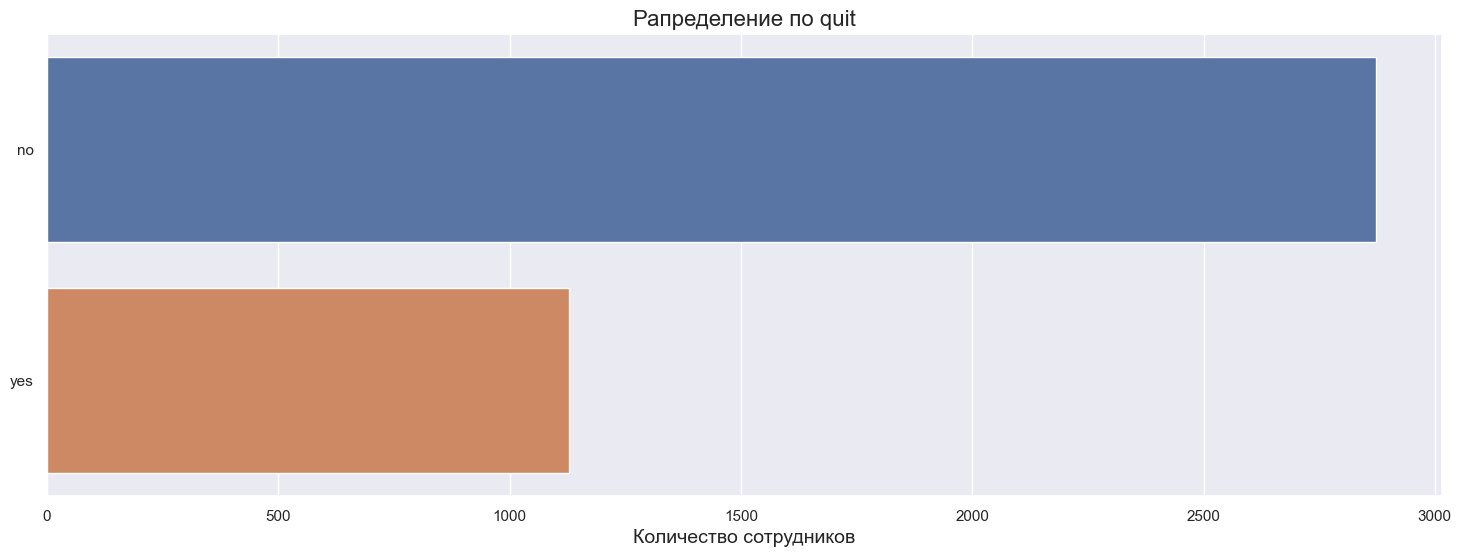

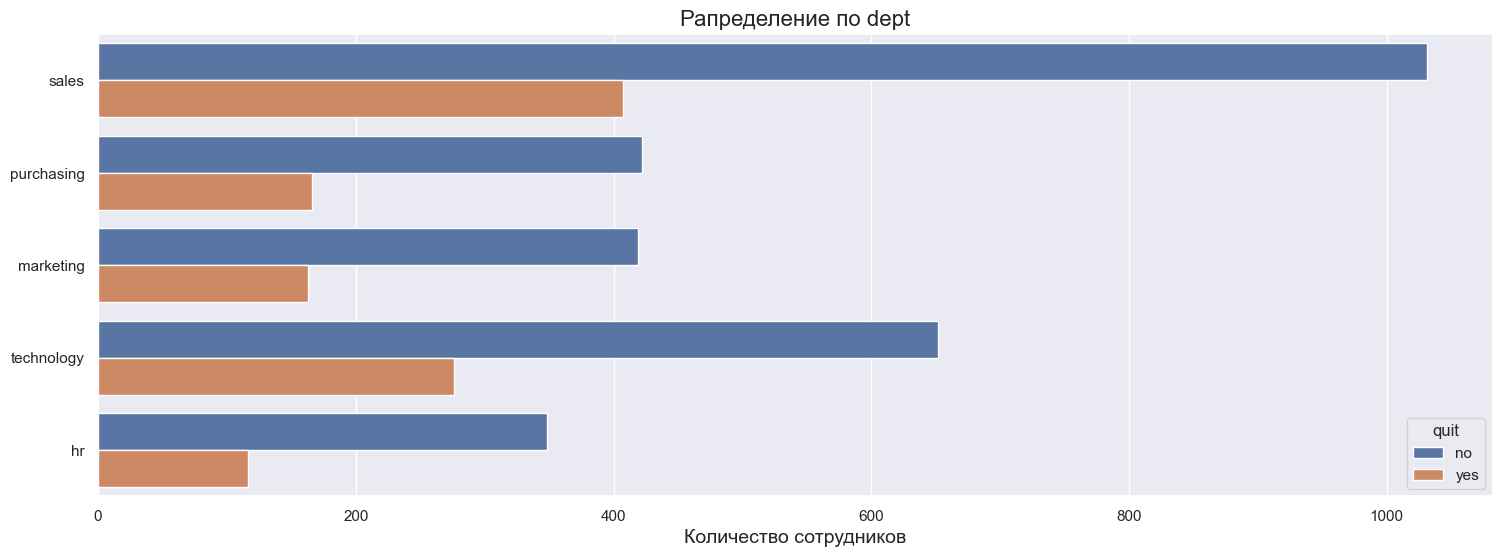

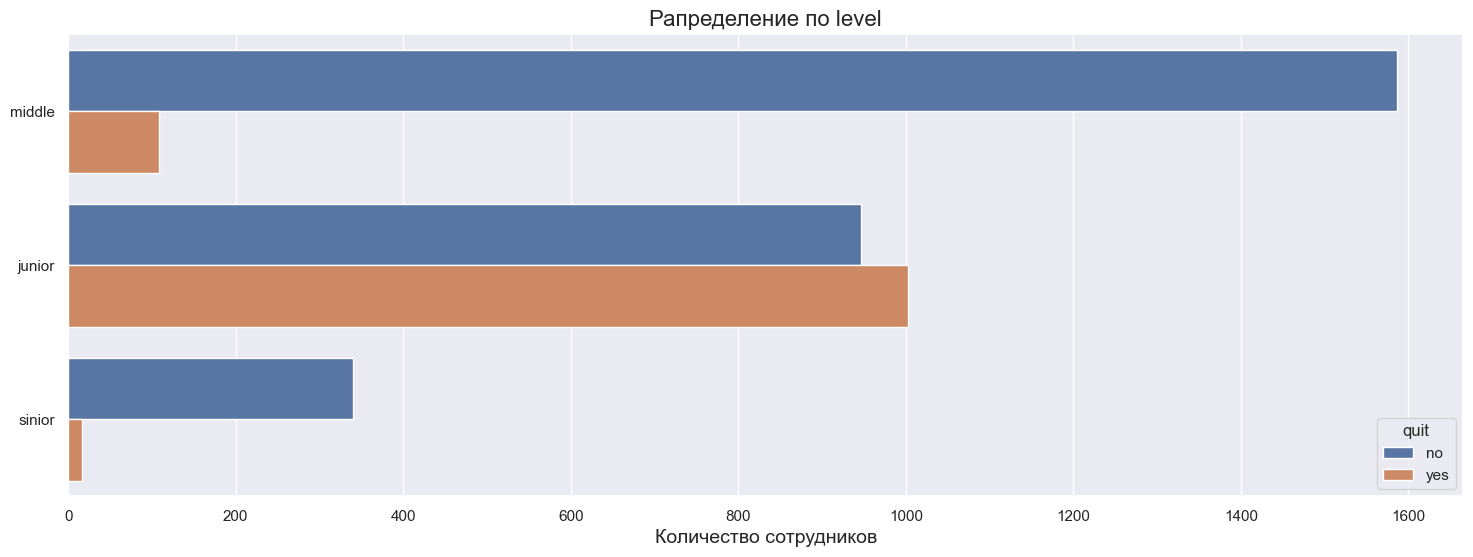

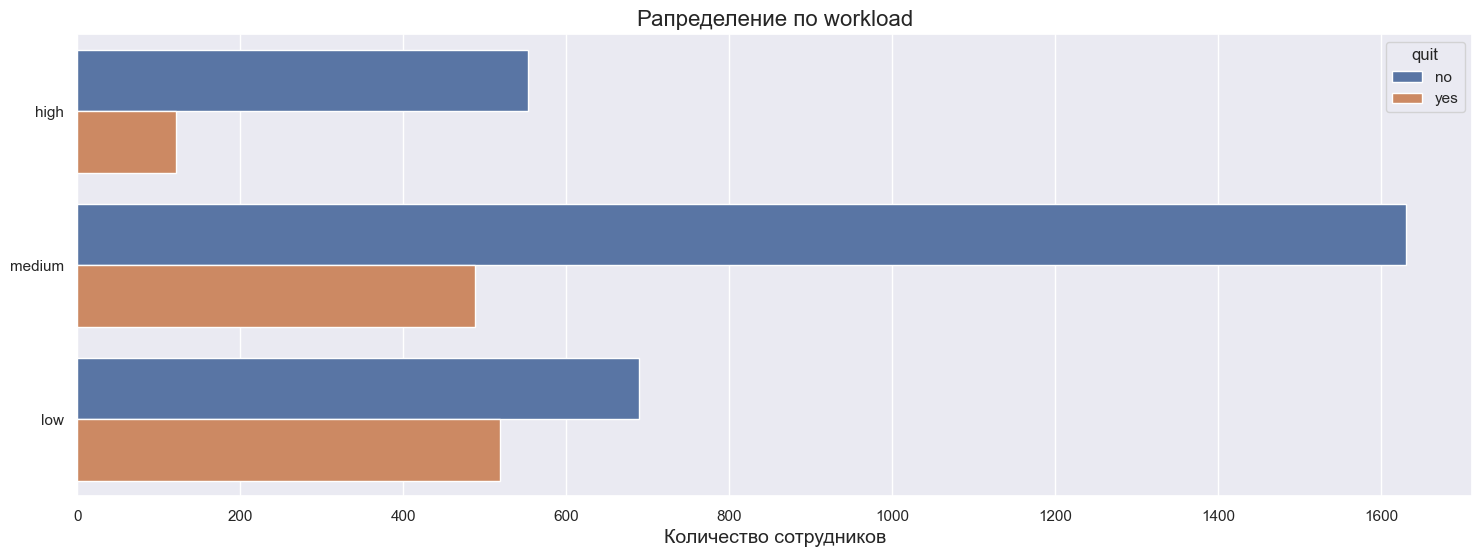

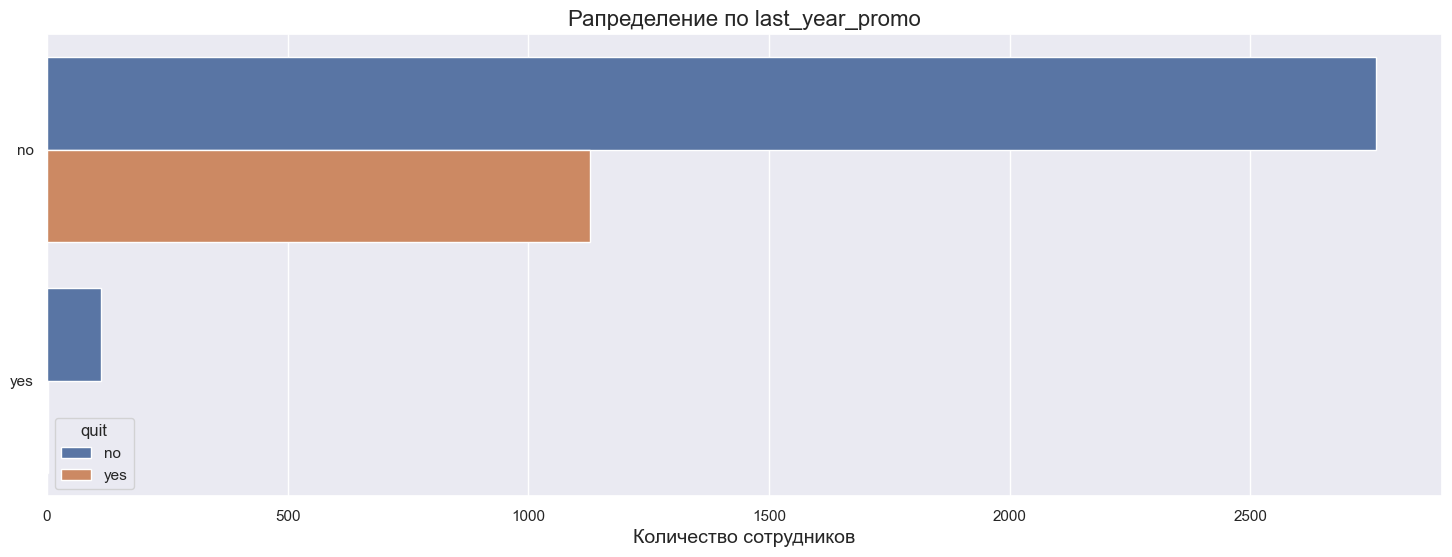

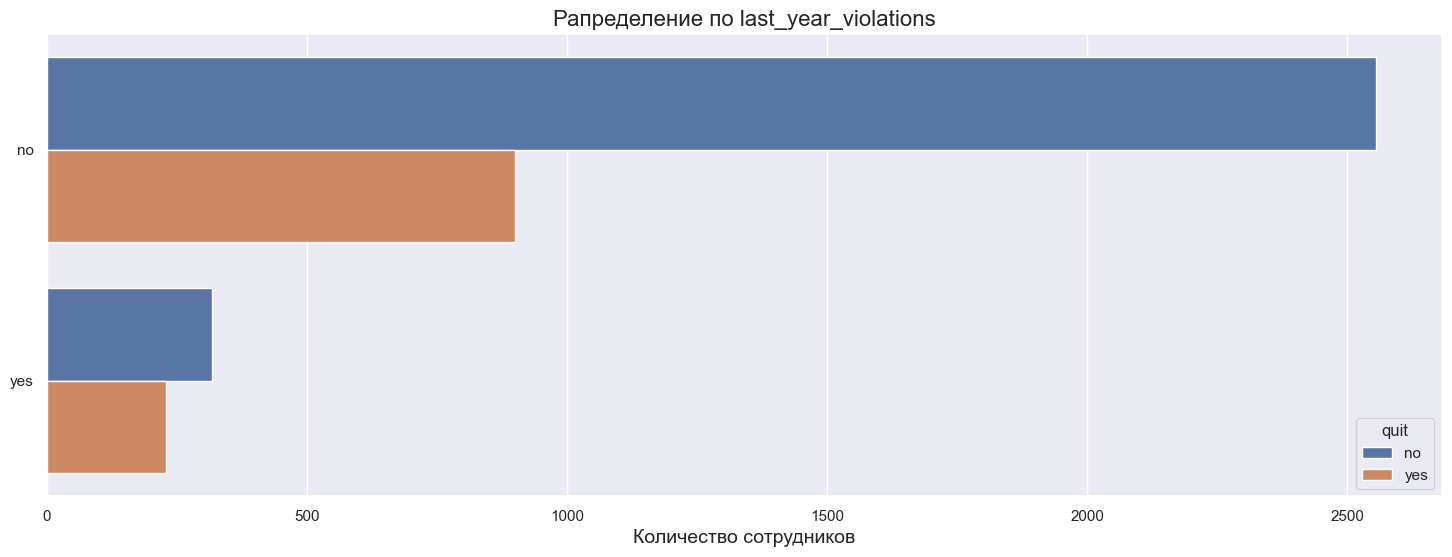

In [59]:
vis_cat_features(train_quit, cat_features_col, 'quit')

##### Выводы

По категориальным признакам можно сделать следующие выводы:

-  Целевая переменная `quit` - наблюдается значительный дисбаланс классов, будем обрабатывать в пайплайне при необходимости.
- Наибольшее количество увольнений в отделах: Sales, Technology, Marketing
- Наименьшее количество увольнений в отделах: HR и Purchasing (но это самые маленькие отделы)
- level:
    - Junior сотрудники - самый высокий процент увольнений
    - Middle сотрудники - средний уровень увольнений
    - Senior сотрудники - наиболее стабильная группа
- По нагрузке - рсикованная группа с высокой нагрузкой
- Подавляющее большинство уволившихся не получали повышения в прошлом году
- Сотрудники с нарушениями увольняются значительно чаще

##### Визуализация количественных признаков


Статистика для признака 'salary':
Средние значения по группам:
              mean           std  count
quit                                   
no    37702.228412  15218.977339   2872
yes   23885.106383   9351.599505   1128


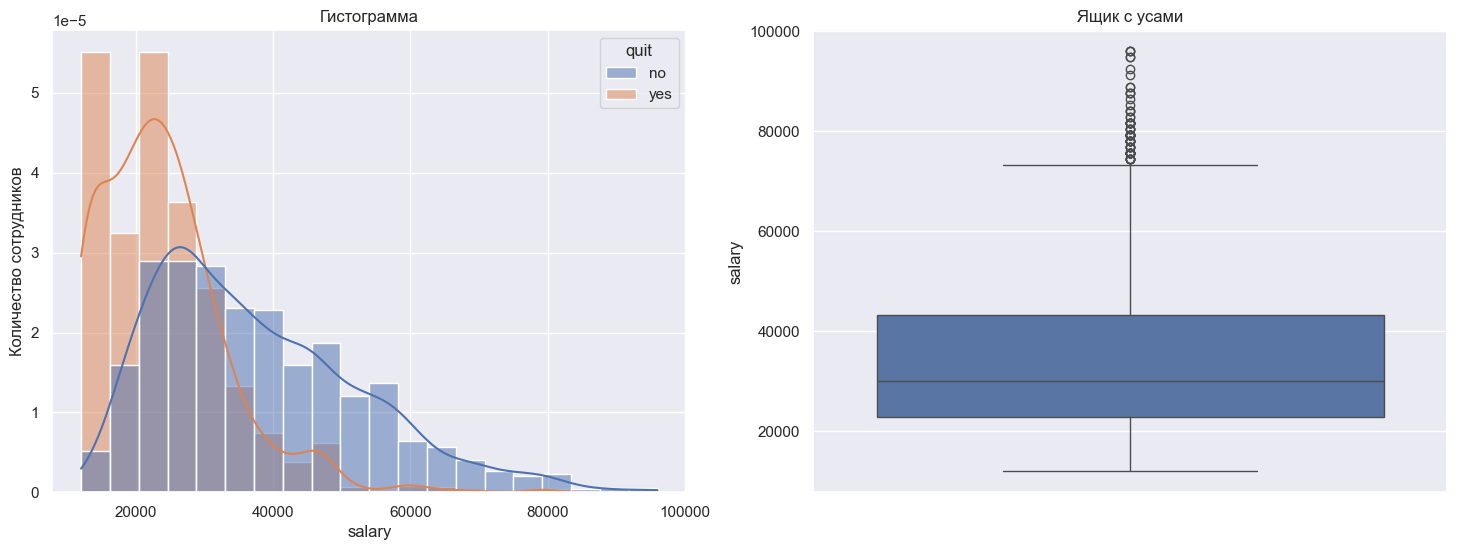

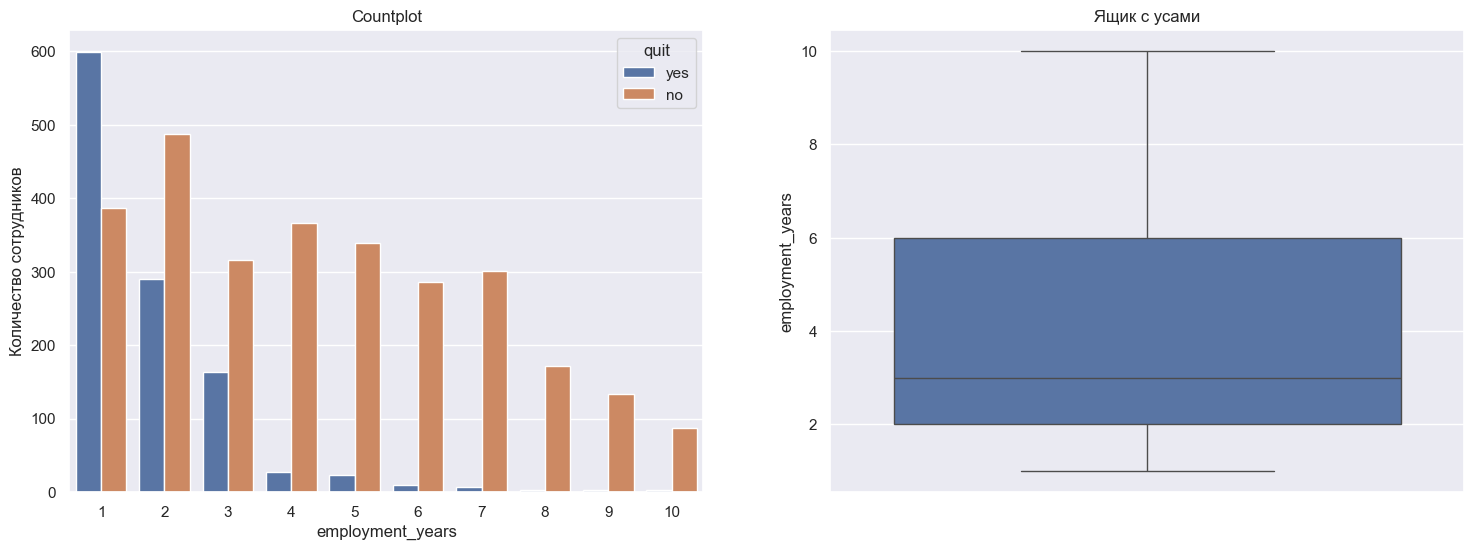

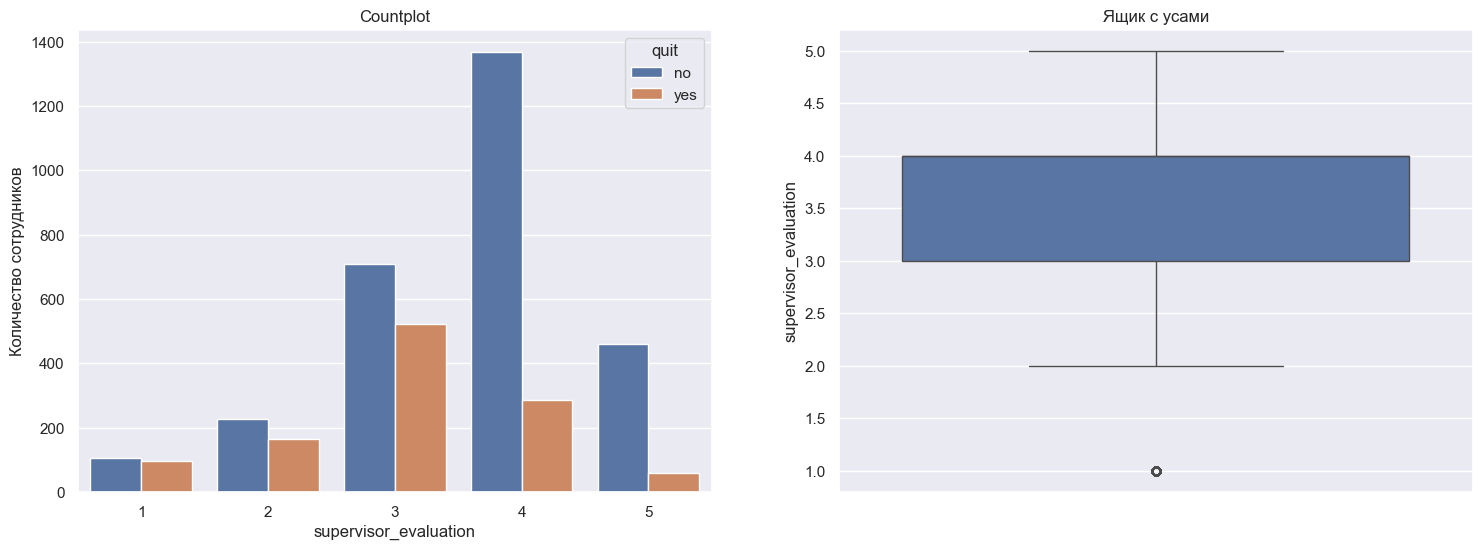

In [60]:
viz_num_features(train_quit,num_features_col,'quit')
viz_num_features(train_quit,num_dis_features_col,'quit', dis=True)

##### Выводы
По количественным признакам можно сделать следующие выводы:

- Переход оценки руководителем от 3 к 4 снижает риск увольнения почти в 2 раза
- Типичный диапазон: 0-4 года (особенно 1-3 года). Наиболее рискованный период: 2-3 года работы в компании
- Уровень зарплаты уволенных ниже тех, что продолжают работать



#### Портрет "Уволившегося сотрудника"

Сотрудник, проработавший в компании 2-3 года, на позиции junior/middle уровня (чаще всего в отделах продаж или технологий), с зарплатой 20000  у.е, работающий под высокой нагрузкой, не получивший повышения в прошлом году, имевший оценки руководителя 3 или ниже, и/или имевший нарушения дисциплины.

Разработанная модель предсказания уровня удовлетворенности подтверждает ключевые факторы риска:
- Низкая оценка руководителя (особенно 1-3 балла) - самый сильный предиктор
- Отсутствие продвижения за последний год

Заключение: Типичный уволившийся сотрудник - это не "плохой работник", а часто "недооцененный работник" в условиях высокой нагрузки без адекватного вознаграждения и карьерных перспектив. Основные драйверы увольнений - системные, а не индивидуальные факторы.

#### Проверка гипотезы

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников.

In [61]:
df = test_target_job_satisfaction_rate.merge(test_target_quit, on='id')
df.set_index('id').groupby('quit')['job_satisfaction_rate'].mean()

quit
no     0.612040
yes    0.387713
Name: job_satisfaction_rate, dtype: float64


Статистика для признака 'job_satisfaction_rate':
Средние значения по группам:
          mean       std  count
quit                           
no    0.612040  0.199367   1436
yes   0.387713  0.185784    564


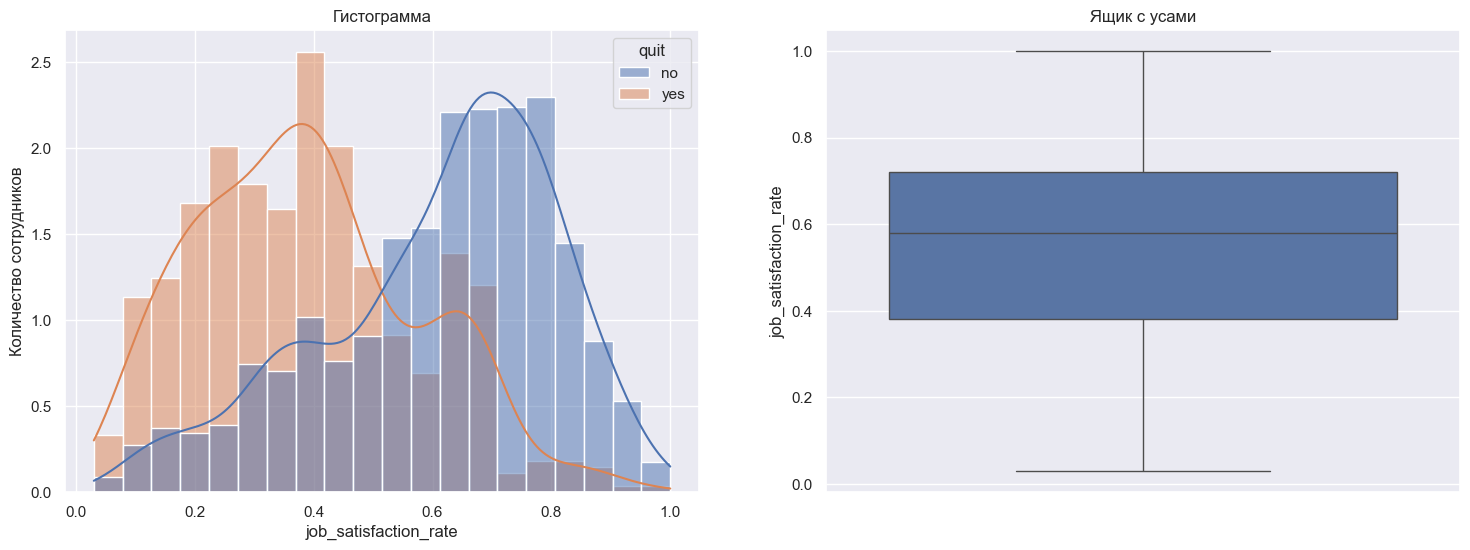

In [62]:
viz_num_features(df,['job_satisfaction_rate'],'quit')

#### Выводы

Утверждение аналитиков подтверждаются - уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, что подтверждается распределением признака. Средняя оценка для ушедших работников составила 0.387713 а для оставшихся 0.612040

### Добавление нового входного признака

In [63]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.648000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


### Подготовка данных

dept, last_year_promo, last_year_violations — нужно кодировать с помощью OneHotEncoder.  
level, workload — нужно кодировать с помощью OrdinalEncoder.  
employment_years, supervisor_evaluation, salary, job_satisfaction_rate - нужно масштабировать.  

In [64]:
train_quit = train_quit.set_index('id')
test_features_quit = test_features_quit.set_index('id')

In [65]:
train_quit.head()
# test_features_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.648000
814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [66]:
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']

test_features_quit = test_features_quit.merge(test_target_quit, on='id', how='left')
X_test = test_features_quit.drop(['quit'], axis=1)
y_test = test_features_quit['quit']
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [67]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [68]:
# закодируем целевой признак
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test) 

In [69]:
print(dict(enumerate(label_encoder.classes_)))

{0: 'no', 1: 'yes'}


### Пайплайны. Обучение модели

In [70]:
   
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
 
param_grid = [
     {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__class_weight': ['balanced', None]
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__class_weight': ['balanced', None]
    }
    
]

In [71]:
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# обучаем лучшую модель на тренировочных данных
r_search.fit(X_train, y_train)

# выводим на экран лучшую модель, её параметры и метрику ROC-AUC на тренировочной выборке
print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print(f'Параметры лучшей модели:\n{r_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(r_search.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [72]:
best_model = r_search.best_estimator_
print(f'Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: {round(r_search.best_score_,4)}')

Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: 0.9221


In [73]:
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_score(y_test, r_search.predict_proba(X_test)[:, 1]),4)}')


Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9225


/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [74]:
cv_results = pd.DataFrame(r_search.cv_results_)

# Добавляем колонку с   моделями 
cv_results['модель'] = cv_results['param_models'].apply(lambda x: x.__class__.__name__)

detailed_names = {

    'mean_score_time': 'время_предсказания',
    'mean_test_score': 'метрика_на_кроссвалидации',
    'rank_test_score': 'место_по_метрике'
}

cv_results_renamed = cv_results.rename(columns=detailed_names)
best_models = (
    cv_results_renamed
    .sort_values('место_по_метрике')
    .reset_index()
)
# Выводим интересующие нас cтолбцы
best_models[['модель', 'время_предсказания', 'метрика_на_кроссвалидации', 'место_по_метрике']]
# cv_results_renamed

,модель,время_предсказания,метрика_на_кроссвалидации,место_по_метрике
0,DecisionTreeClassifier,0.009910,0.922136,1
1,DecisionTreeClassifier,0.015291,0.919114,2
2,LogisticRegression,0.014994,0.919059,3
3,LogisticRegression,0.013981,0.919014,4
4,LogisticRegression,0.014234,0.918856,5
5,DecisionTreeClassifier,0.014040,0.905784,6
6,DecisionTreeClassifier,0.016332,0.901181,7
7,DecisionTreeClassifier,0.010036,0.899192,8
8,DecisionTreeClassifier,0.013145,0.877239,9
9,DecisionTreeClassifier,0.014490,0.866716,10


#### Выводы

Модель с оптимальными гиперпараметрами демонстрирует хорошую сбалансированность между точностью, скоростью и устойчивостью.   
Полученная метрика ROC - 0.9234 на тестовой выборке свидетельствует о практической применимости модели для решения поставленной задачи.  
Модель не показывает признаков переобучения и обладает удовлетворительной обобщающей способностью. 

#### Анализ важности признаков

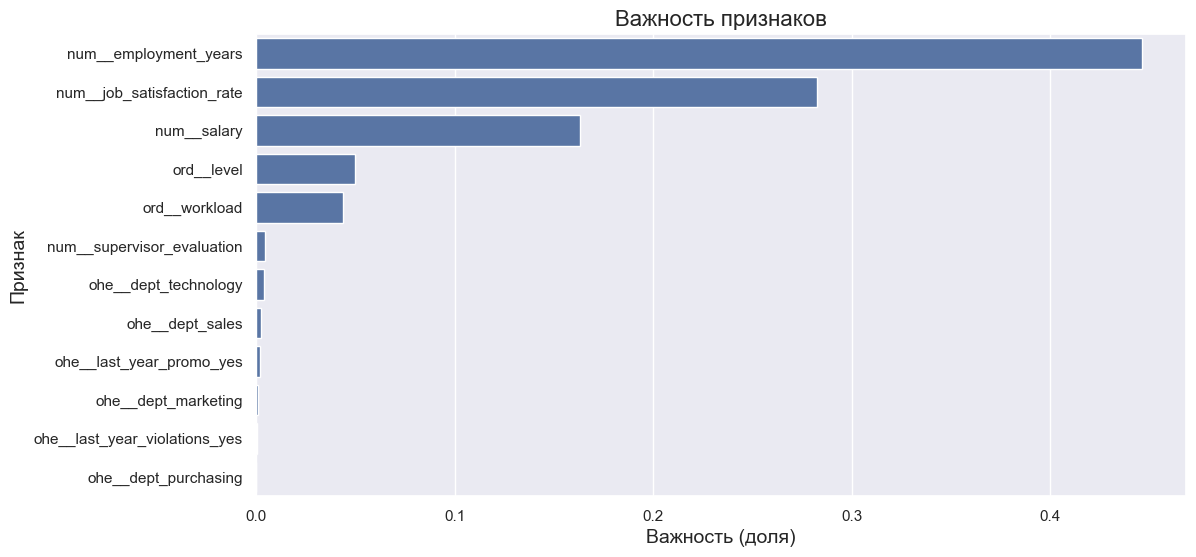

In [75]:
feature_importances = pd.DataFrame(
    {
        'Feature': best_model.named_steps['preprocessor'].get_feature_names_out(),
        'Importance': best_model.named_steps['models'].feature_importances_
    })
# отсортируйте таблицу от большего значения важности к меньшему и выведите результат
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data = feature_importances,
    y = 'Feature',
    x = 'Importance'
)
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)
plt.show()


Модель определяет следующие три признака как наиболее важные для прогнозирования:

employment_years — длительность работы в компании - лидер по важности
job_satisfaction_rate — уровень удовлетворённости сотрудника - второй по значимости  
salary - зарплата - третий по важности  

Это свидетельствует о том, что материальные и карьерные факторы оказывают наибольшее влияние на исследуемую целевую переменную.

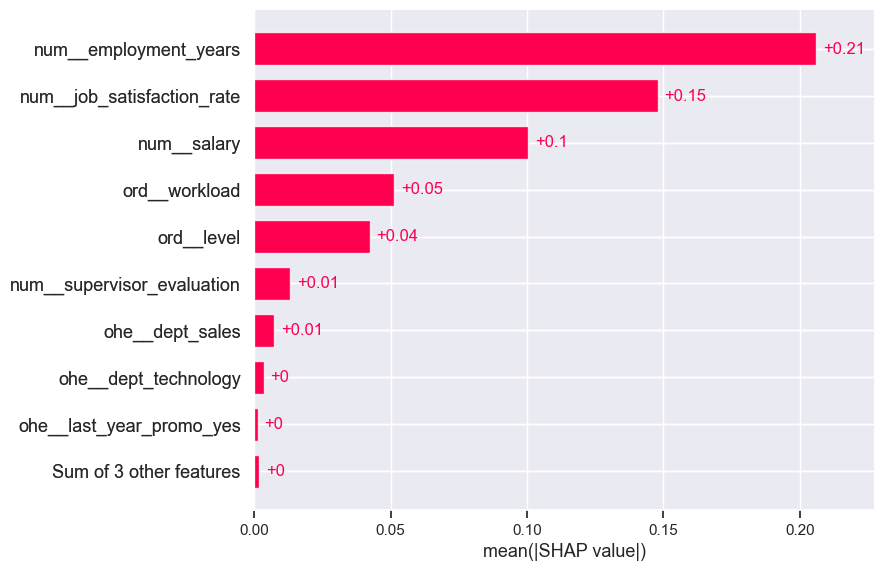

In [76]:
# Получаем модель и препроцессор
tree_model = best_model.named_steps['models']
preprocessor = best_model.named_steps['preprocessor']

# Преобразуем данные
X_transformed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Создаем объяснитель
explainer = shap.TreeExplainer(tree_model)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_transformed)[:,:,1]

# Создаем Explanation объект
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_transformed,
    feature_names=feature_names
)

shap.plots.bar(explanation, max_display=10)

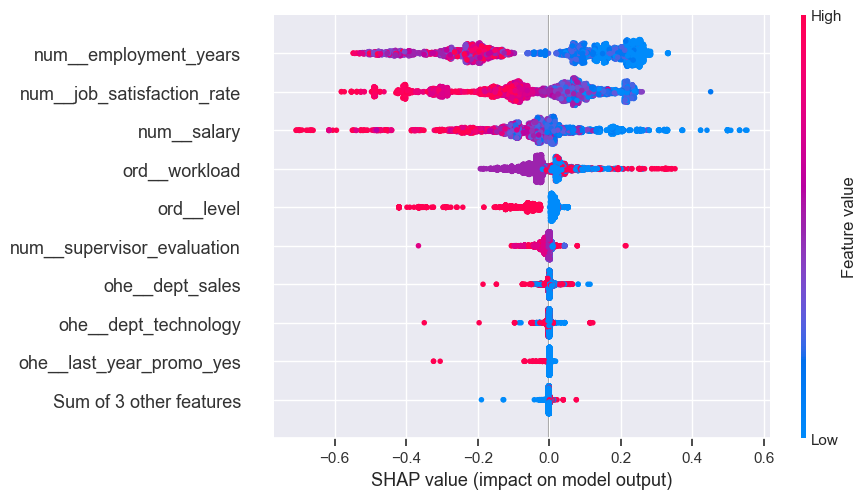

In [77]:
shap.plots.beeswarm(explanation, max_display=10)


#### Выводы 

Доминирующие факторы:

- employment_years — Наиболее значимый признак с важностью 0.21
- job_satisfaction_rate — уровень удовлетворённости сотрудника -  Второй по важности признак (0.15)
- salary - зарплата - третий (0,10)

#### Анализ остатков модели

Accuracy =  0.893
Precision =  0.7675840978593272
Recall =  0.8900709219858156


/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


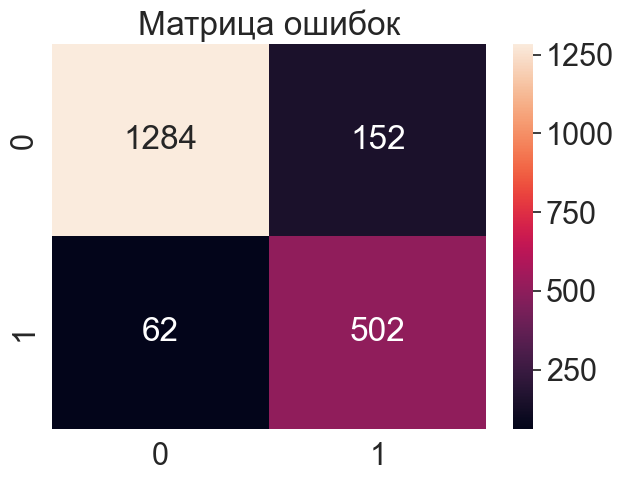

In [78]:
y_pred = r_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

plt.figure(figsize = (7,5))
cm = confusion_matrix(y_test, y_pred)

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d');
plt.title('Матрица ошибок')
print('Accuracy = ',acc)
print('Precision = ',precision)
print('Recall = ',recall)

In [79]:
# поиск порога
y_pred_proba = r_search.predict_proba(X_test)[:,1]

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
best_idx = np.argmax(tpr - fpr)
best_threshold_youden = thresholds_roc[best_idx]

def predict_with_threshold(model, X, threshold=0.5):
    probs = model.predict_proba(X)[:, 1]  # Вероятности положительного класса
    return (probs >= threshold).astype(int)

y_pred_optimal = predict_with_threshold(best_model, X_test, threshold=best_threshold_youden)
best_threshold_youden

/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.7263952234845332

/Users/arseniybartenev/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


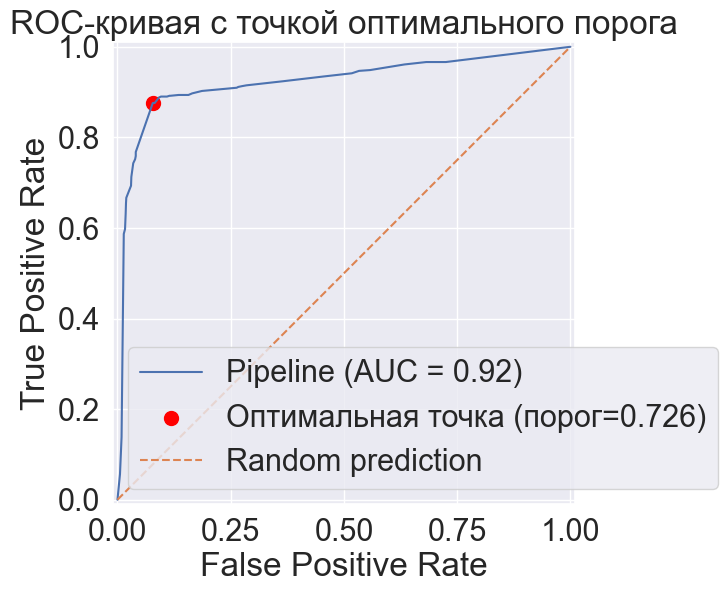

In [80]:
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', s=100, 
            label=f'Оптимальная точка (порог={best_threshold_youden:.3f})')
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая с точкой оптимального порога')
plt.legend()
plt.grid(True)
plt.show()

Accuracy =  0.909
Precision =  0.8151815181518152
Recall =  0.875886524822695


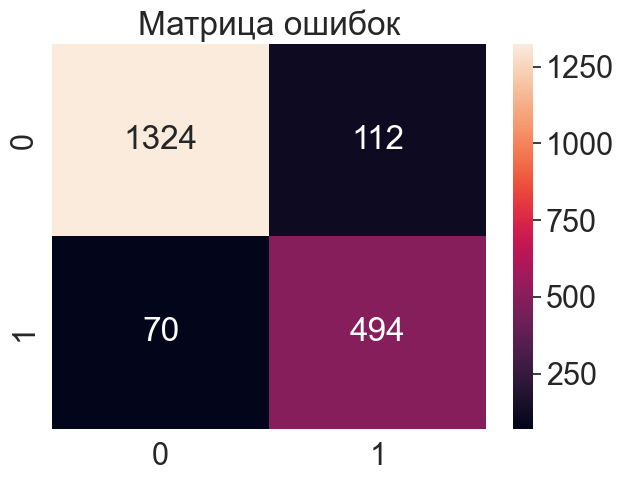

In [81]:
acc = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)

plt.figure(figsize = (7,5))
cm = confusion_matrix(y_test, y_pred_optimal)

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d');
plt.title('Матрица ошибок')
print('Accuracy = ',acc)
print('Precision = ',precision)
print('Recall = ',recall)

#### Выводы

Матрица ошибок изначально показала ошибки 1 и 2 рода. Рекомендуется использовать порог 0.726 как оптимальный баланс между обнаружением увольнений и точностью предсказаний. Но повышается ошибка второг рода, которую нам желательно минимизировать.

## Итоги
<b>  </b>
<b>Разработали две модели машинного обучения для:</b>  

- Предсказания уровня удовлетворённости сотрудников работой в компании.

- Предсказания вероятности увольнения сотрудников.

Цель — снизить риски внезапных увольнений ключевых сотрудников и улучшить управление персоналом.



1. <b>Предсказание уровня удовлетворённости</b>  
Лучшая модель: DecisionTreeRegressor с подобранными гиперпараметрами.

Ключевые признаки, влияющие на удовлетворённость:

- Оценка руководителя — наиболее значимый фактор.
- Зарплата — второй по важности признак.
- Стаж работы в компании — третий по значимости.

Выводы по модели:

Модель интерпретируема, остатки распределены нормально, гомоскедастичность подтверждена.  
Наибольшее влияние на удовлетворённость оказывают материальные и карьерные факторы.   
Роль руководителя в оценке сотрудника критически важна для их удовлетворённости.  

2. <b>Предсказание увольнения сотрудников</b>  
Лучшая модель: DecisionTreeClassifier с добавленным признаком прогнозируемой удовлетворённости.

Ключевые признаки, влияющие на увольнение:
Стаж работы — наиболее значимый фактор (пик риска — 2–3 года в компании).  
Уровень удовлетворённости работой — второй по важности.  
Оценка руководителя и зарплата — также имеют существенное влияние.  

Метрики модели:
ROC-AUC на тесте: 0.9234  
Accuracy: 0.91  
Precision: 0.82  
Recall: 0.875  
Оптимальный порог классификации: 0.726 (баланс между точностью и полнотой).  

3. <b>Портрет сотрудника с высоким риском увольнения  </b>  

Стаж: 2–3 года в компании.  
Должность: Junior или Middle.  
Отдел: Sales, Technology или Marketing.  
Нагрузка: Высокая.  
Повышение за последний год: Отсутствует.  
Оценка руководителя: 3 или ниже.  
Нарушения дисциплины: Возможны.  
Удовлетворённость работой: Низкая (≤ 0.39).  

4. <b>Подтверждённые гипотезы</b>  
Уровень удовлетворённости работой действительно влияет на вероятность увольнения:  

Средняя удовлетворённость у уволившихся: 0.39.  
Средняя удовлетворённость у оставшихся: 0.61.  

Основные драйверы увольнений — системные факторы (отсутствие повышений, низкая оценка руководителя, высокая нагрузка), а не индивидуальные качества сотрудников.

5.<b> Практические рекомендации для HR-отдела</b>  
Для профилактики увольнений:  
- Фокус на сотрудниках со стажем 2–3 года — проводить регулярные check-in встречи.  
- Мониторинг сотрудников с низкой оценкой руководителя (≤ 3 баллов) — внедрить программы менторства и обратной связи.
- Анализ нагрузки — перераспределять задачи в отделах с высокой текучкой (Sales, Technology).
- Система премирования и повышений — рассмотреть возможность более частых пересмотров зарплат и карьерных перспектив.

Для повышения удовлетворённости:
- Развитие управленческих компетенций руководителей — их оценка сильно влияет на удовлетворённость сотрудников.
- Регулярные опросы удовлетворённости с использованием модели для прогнозирования — снизить зависимость от ручных анкет.
- Программы адаптации и удержания для сотрудников на позициях Junior и Middle.

По использованию моделей:
- Внедрить модель предсказания увольнений в HR-систему с автоматическим формированием списков риска.
- Использовать модель удовлетворённости для точечных интервенций и улучшения условий труда.
- Регулярно обновлять модели с учётом новых данных.
